In [1]:
import actr
import pickle
import random
import os
import fnmatch
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import groupby
import json
import re

### Observed Issues:
(see file "current_issues")

- Recency effect still too weak.

- Primacy effect too strong.



#### Number of words in each list i.e. list_length should be n where (n-2)%3 == 0 because 2 neutral words are added in each list.

#### The adjustable parameters in this experiment code.
    - number of agents (top of next cell)
    - experimental conditions (further below) --> multiple conditions can be set in a list of lists [[rehearsal time1, num words per list 1], [rehearsal time 2, num words per list 2], ...]
    - Number of lists (further below)
#### Adjustable parameters in ACT-R
    - :declarative-num-finsts 21 ; number of items that are kept as recently retrieved (Change it to 5) 
    - :declarative-finst-span 21 ; how long items stay in the recently-retrieved state (5,100)

In [2]:
help(actr)

In [3]:
### Experiment part ###

def __init__(iteration, rehearsal_time, list_length, list_amount=3, path="."):
    subject = ''

    current_list = ''
    
    associated_list = ''

    recalled_words = defaultdict(list)

    rehearsed_words =  defaultdict(lambda: defaultdict(int))

    #list_amount = 3   # No of lists (100, 200, 1000, 2000 AND 5000)

    #Set below where function is actually called
    list_length = list_length   # No of words in a list
    rehearsal_time = rehearsal_time  # No of seconds for which rehearsal happens and each word is shown

    delay = 1  #delay between rehearsal and recall

    recall_time = 90
    
    #distractor_time = 30 #set further below
    
    word_lists_dict = defaultdict(list)
    
    # Ensure there are enough unique words to create the word lists
    word_dict = {"positive": ["positive" + str(i) for i in range(999)],
                 "negative": ["negative" + str(i) for i in range(999)],
                 "neutral": ["neutral" + str(i) for i in range(999)]}

    filename = f'{path}\words_{list_length}_lists_{list_amount}_rh_time_{rehearsal_time}_rec_time_{recall_time}_delay_{delay}_{iteration}.txt'
    
    results = {}

    results['x'] = {'data': [], # will be appended later in the analytics function
                          'info': "Storing range(len(word_lists_dict[0])) here"}

    results['rehearse_frequency'] = {'data': None,# will be appended later in the analytics function
                                     'info': "Storing list(rehearse_frequency.values()) here"}

    results['recall_probability'] = {'data': None, # will be appended later in the analytics function
                                        'info': "Storing list(recall_probability.values()) here"}

    results['first_recall'] = {'data': None, # will be appended later in the analytics function
                               'info': "Storing list(first_probability.values()) here"}
    
    results['pli'] = {'data': None, # will be appended later in the analytics function
                         'info': "Storing avg PLIs per agent here"}

    with open(filename, 'w') as outfile:
        json.dump(results, outfile)

    with open(filename) as json_file:
        results = json.load(json_file)
#         #print(results)
    
    globals().update(locals())  ## Making everything public, worst code you can ever write!!

In [4]:
def add_words(i, list_length):
    '''
    Add the words to the word lists, ensures valence categories are balanced
    '''
    global word_lists_dict

    amnt_wanted = list_length #-2)/3 #not needed here because Murdock experiment # Amount of each valence wanted, minus 2 neutrals controlling for primacy
    amt_positive, amt_negative, amt_neutral, count = 0, 0, 0, 0
    while len(word_lists_dict[i]) != list_length:
        count += 1
        #print(f"...................{count,word_lists_dict[i]}")
        if count >= 9999: # IF it takes too long to create a unique list at random, start over
            word_lists_dict[i] = []
            add_words(i, list_length)
        if len(word_lists_dict[i]) == 0: # Place two neutral words at the start to control for primacy effects
            word_to_add1 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            word_to_add2 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            if word_to_add1 not in word_lists_dict[i] and word_to_add2 not in word_lists_dict[i] and word_to_add1 != word_to_add2:
                word_lists_dict[i].append(word_to_add1)
                word_lists_dict[i].append(word_to_add2)
            else:
                continue # skip this loop iteration                   
        else: 
            random_valence = random.choice(["positive", "negative", "neutral"])
            word_to_add = word_dict[random_valence][random.randint(0, len(word_dict[random_valence])-1)]
            if word_to_add not in word_lists_dict[i] and word_lists_dict[i][-1] not in word_dict[random_valence] and \
               amt_positive <= amnt_wanted and amt_negative <= amnt_wanted and amt_neutral <= amnt_wanted:
                if random_valence == "positive" and amt_positive < amnt_wanted:
                    amt_positive += 1
                elif random_valence == "negative" and amt_negative < amnt_wanted:
                    amt_negative +=1
                elif random_valence == "neutral" and amt_neutral < amnt_wanted:
                    amt_neutral +=1
                else:
                    continue # skip this loop iteration
                word_lists_dict[i].append(word_to_add)

def create_lists(list_amount=3, list_length=2):
    '''
    Create the wordlists used during the free recall tasks 
    '''  
    global word_lists_dict 

    for i in range(list_amount):
        print(f'List {i+1}/{list_amount} created!', end="\r")
        add_words(i, list_length)

    # Save the dictionary to a .pickle file, so we do not have to create the word lists everytime we run the model                    
    file = open(f"word_lists/word_lists_dict_{list_length}_{list_amount}.pickle","wb")
    pickle.dump(word_lists_dict, file)
    file.close()
    return word_lists_dict

# Check if the word lists already exist, else create new word lists
def check_and_create_lists():
    global word_lists_dict
    try:
        file = open(f"word_lists/word_lists_dict_{list_length}_{list_amount}.pickle","rb")
        #file = open(f"word_lists_dict_100_items_only.pickle","rb")
        word_lists_dict = pickle.load(file)  
        file.close()
        print("\nSuccesfully loaded the word lists!\n")
    except FileNotFoundError:
        print("\nCreating word lists!\n")
        #amount_to_create = list_amount                              
        word_lists_dict = create_lists(list_amount,list_length)

def display_word_lists():
    '''
    Display the word lists loaded/created
    '''
    for key, value in word_lists_dict.items():
        print(f'List {key}:\n {value}\n')

def close_exp_window():
    '''
    Close opened ACT-R window
    '''
    return actr.current_connection.evaluate_single("close-exp-window")


def prepare_for_memorization():
    '''
    Enable rehearsing productions to start the memorization phase 
    '''    
    enable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "rehearse-first-default", "rehearse-second-default", "rehearse-third-default",
                    "rehearse-fourth-default", "rehearse-it", "forget-word-1", "forget-word-2",
                    "forget-word-3", "forget-word-4", "rehearse-it-wrong-word", "skip-rehearse-1",
                  "skip-rehearse-2", "skip-rehearse-3", "skip-rehearse-4", "attend-new-word"]
    
    disable_list = ["retrieve-a-word", "recall-a-word", "stop-recall"]
    
    for prod in enable_list:
        actr.penable(prod)
        
    for prod in disable_list:
        actr.pdisable(prod)
        
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff)     
    
    actr.goal_focus("goal") # set goal to start memorization

    
def prepare_for_recall(distractor=0): 
    '''
    Disable rehearsing productions, and clearing buffer contents to start the recalling phase 
    '''
    
    if distractor: #disable distractor or memorization PRs
        
        disable_list = ["crowd-out-wm", "continue-task"]
    
    else:
        
        disable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "rehearse-first-default", "rehearse-second-default", "rehearse-third-default",
                    "rehearse-fourth-default", "rehearse-it", "forget-word-1", "forget-word-2",
                    "forget-word-3", "forget-word-4", "rehearse-it-wrong-word", "skip-rehearse-1",
                  "skip-rehearse-2", "skip-rehearse-3", "skip-rehearse-4", "attend-new-word"]
    
    #enable list is the same either way
    enable_list = ["retrieve-a-word", "recall-a-word", "stop-recall"]
    
    for prod in disable_list:
        actr.pdisable(prod)

    for prod in enable_list:
        actr.penable(prod)
        
    actr.run(delay, False) 
    
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff) 

        
def prepare_for_distractor(): 
    '''
    Disable rehearsing productions, and clearing buffer contents to start the distractor task 
    '''
    disable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "rehearse-first-default", "rehearse-second-default", "rehearse-third-default",
                    "rehearse-fourth-default", "rehearse-it", "forget-word-1", "forget-word-2",
                    "forget-word-3", "forget-word-4", "rehearse-it-wrong-word", "skip-rehearse-1",
                  "skip-rehearse-2", "skip-rehearse-3", "skip-rehearse-4", "attend-new-word"]
    
    enable_list = ["crowd-out-wm", "continue-task"]
    
    for prod in disable_list:
        actr.pdisable(prod)

    for prod in enable_list:
        actr.penable(prod)
        
    actr.run(delay, False) 
    
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff) 

def setup_dm(word_lists_dict, rumination_chunks=0):
    '''
    Add words to declarative memory, since it can be assumed the test subjects know the English language already
    '''
    #print("\n\n############################################# Inside setup_dm i.e. Declarative Memory")
    
    colour_conversion = {'pos': 'GREEN', 'neg': 'RED', 'neu': 'BLACK'}
    for list_idx, word_list in word_lists_dict.items():
        
        for idx, word in enumerate(word_list):
            valence = ''.join([char for char in word if not char.isdigit()])[:3]
            actr.add_dm(('item'+str(idx)+"-"+str(list_idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],
                        'context', 'list'+str(list_idx), 'type', 'on-task'))
    #         if idx == 0:
    #             print("\n Emaple of a chunk added in Declarative Memory is \n")
    #             print('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],"\n")

    
    if rumination_chunks > 0:
        for i in range(rumination_chunks):
            actr.add_dm(('rumination'+str(i), 'isa', 'memory', 'word', 'rumination'+str(i),
                         'valence', 'RED', 'context', 'none', 'type', 'rumination'))
    
        #set creation times and times of prior reference for each chunk  
    #actr.sdp(':reference-list', list(np.linspace(0, -1000, 50))) #':creation-time', -1000, 
     
    
def setup_experiment(human=True):
    '''
    Load the correct ACT-R model, and create a window to display the words
    '''
#     print("\n\n############################################# Inside setup_experiment")
#     print(f'\nSubject = {subject}\n')  

    loaded = None
    if subject == "controls":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\general_free_recall_model_v4.7.lisp")
        #loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\csm_free_recall_model.lisp")
    elif subject == "depressed":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\rumination_free_recall_model_v1.lisp")
    
    #print("\n\n############################################# Inside setup_experiment")
    #print(f'\nLoaded Act-r model = {loaded}\n')  

    window = actr.open_exp_window("Free Recall Experiment", width=1024, height=768, visible=human) # 15inch resolution window
    actr.install_device(window) 
    return window    

# def record_associated_list(item):
#     '''
#     Register which list the recalled words belong to (to identify prior-list intruisions)
#     '''
#     associated_list = item

def record_words_recalled(item1, item2):
    '''
    Register which words were recalled during the experiment for a specific wordlist and strip the numbers
    '''
    valence = ''.join(char for char in item1 if not char.isdigit())
    item_idx = ''.join(char for char in item1 if char.isdigit())
    context = str(item2)
    
    recalled_words[current_list].append((valence, item_idx, context))
    
    #print(valence, item_idx, context)

def record_words_rehearsed(item):
    '''
    Register amount of rehearsals per word for each wordlist
    '''
    rehearsed_words[current_list][item] += 1

def create_lplot(idx, xlabel, ylabel, x, y, xticks_len, filename, ytick_range=None, show=False):
    '''
    Create line plot using matplotlib
    '''
    plt.figure(idx)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.xticks(np.arange(0, xticks_len, 1)) 
    plt.yticks(ytick_range)
    #plt.savefig("images/"+subject+"_"+filename, bbox_inches='tight')
    if show:
        plt.show()    

        
def create_result_dict():
    '''
    Use a module-level function, instead of lambda function, to enable pickling it
    '''
    return defaultdict(int)

## Creating different pickle files to store results from multiple hyper-parameter values.


def analysis(wlist_amount, show_plots=False):
    '''
    Review results of the recall experiment
    '''
    global results
    result_dict = defaultdict(create_result_dict) # instead of defaultdict(lambda: defaultdict(int))
    first_recall = defaultdict(int)
    recall_probability = defaultdict(int)
    rehearse_frequency = defaultdict(int)
    pli_dict = defaultdict(int)
    transitions_amnt = 0
    thought_train_len = []
    

    for key, val in recalled_words.items():
        thought_train_len.extend([(k, sum(1 for _ in count)) for k, count in groupby([val[0] for val in val[2:]])])
        for idx, (retrieved_word, item_num, _) in enumerate(val[2:]):
            if idx != 0:
                if retrieved_word != val[2:][idx-1][0]:
                    transitions_amnt += 1/wlist_amount # average over word lists

    print(f'Avg. Amount of recall transitions = {int(transitions_amnt)}')
    neg_thought_train_len = 0
    neg_divider = 0.0001
    for x in thought_train_len:
        if x[0] == 'negative':
            neg_divider += 1
            neg_thought_train_len += x[1]
    print(f'Avg. Negative Thought train length = {round(neg_thought_train_len/neg_divider, 3)}')            
    
    for list_num, wlist in word_lists_dict.items():
        if list_num < wlist_amount:
            for key, val in recalled_words.items():
                if key==list_num:
                    first_recall[wlist.index(''.join(val[0][0:2]))] += 1
                    for idx, word in enumerate(wlist):
                        first_recall[idx] += 0
                        if ((''.join(char for char in word if not char.isdigit()), 
                             ''.join(char for char in word if char.isdigit()), val[0][2])) in val:
                            recall_probability[idx] += 1
                        else:
                            recall_probability[idx] += 0
                for retrieved_word, item_num, list_idx in val[2:4]:
                    result_dict["pstart"][retrieved_word] += 1  
                for retrieved_word, item_num, list_idx in val[4:-2]:
                    result_dict["pstay"][retrieved_word] += 1
                for retrieved_word, item_num, list_idx in val[-2:]:
                    result_dict["pstop"][retrieved_word] += 1 
            for key, val in rehearsed_words.items():
                if key==list_num:
                    for idx, word in enumerate(wlist):
                        rehearse_frequency[idx] += rehearsed_words[key][word]
    
    
    for key, val in first_recall.items():
        first_recall[key] = val/wlist_amount

    for key, val in recall_probability.items():
        recall_probability[key] = val/wlist_amount

    for key, val in rehearse_frequency.items():
        rehearse_frequency[key] = val/wlist_amount      
        
    
    #Calculate prior-list intrustions
    #subjects committed an average of 0.61 PLIs per list (Zaromb et al., 2006)
    
    if len(recalled_words) > 1:
        overall_pli = 0
        for key, value in recalled_words.items():
            if key > 0:
                intruding_list = []
                pli = 0
                for word_info in value:
                    associated_list = int(re.findall(r'\d+', word_info[2])[0]) #extract just the number from the context and turn into int
                    if associated_list != key:
                        intruding_list.append(associated_list)
                        pli += 1

                print(f'PLIs on list {key}: {pli}')
                if intruding_list:
                    print(f'The PLIs came from {intruding_list}')
                overall_pli += pli
                
        
            pli_dict[key] = overall_pli
            
        avg_pli = overall_pli/(len(recalled_words)-1)
        print(f'Average number of PLIs: {avg_pli}') #minus 1 because no PLI possible on LIST0
       
    xticks_len = len(word_lists_dict[0])
    
    #results['x']['data'].append(range(len(word_lists_dict[0])))
    #results['xticks_len']['data'].append(len(word_lists_dict[0]) )
    results['rehearse_frequency']['data'] = list(rehearse_frequency.values())
    results['recall_probability']['data'] = list(recall_probability.values())
    results['first_recall']['data'] = list(first_recall.values())
    results['pli']['data'] = list(pli_dict.values())
    
    
    with open(filename, 'w') as outfile:
        json.dump(results, outfile)
        
    create_lplot(0, 'Serial input position', 'Rehearse Frequency', range(len(word_lists_dict[0])), list(rehearse_frequency.values()), 
                xticks_len, f'rehearse_frequency_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', None, show_plots)

    create_lplot(1, 'Serial input position', 'Starting Recall', range(len(word_lists_dict[0])), list(first_recall.values()), 
                xticks_len, f'starting_recall_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', np.arange(0, .5, .1), show_plots)                

    create_lplot(2, 'Serial input position', 'Recall Probability', range(len(word_lists_dict[0])), list(recall_probability.values()), 
                xticks_len, f'recall_probability_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', np.arange(0, 1, .1), show_plots)   
    
#     create_lplot(3, 'Serial input position', 'Accuracy', range(len(word_lists_dict[0])), list(recall_accuracy.values()), 
#                 xticks_len, 'recall_accuracy.png', np.arange(0, 1, .1), show_plots) 

    file = open("results_"+subject+".pickle","wb")
    pickle.dump(result_dict, file)
    file.close()

    return result_dict

def do_experiment(subj="controls", human=False, wlist_amount=2000, distractor_time=0, rumination_chunks=0):
    '''
    Run the experiment
    '''
    check_and_create_lists()
    global word_lists_dict, subject
    
    subject = subj
    
    assert wlist_amount <= len(word_lists_dict), "Chosen too many lists, choose less or create more word lists using function: create_lists()"
    
#     print("###################################################\n")
#     print("The original word list \n")
#     print(display_word_lists())
    
#     print("\n###################################################\n")
#     print("Experiment started, Trying to understand the flow\n")
    
    #buffers_to_clear = ['goal', "imaginal", "retrieval", "production"]
    
    
    actr.reset()
    
    window = setup_experiment(human)
    
    setup_dm(word_lists_dict, rumination_chunks=50)

    for idx, (key, value) in enumerate(word_lists_dict.items()):
        
        #window = setup_experiment(human)

        global current_list
        current_list = idx # keep track for which list words are recalled

        #setup_dm(key, value)
        
        prepare_for_memorization()
        
        actr.mod_focus('context', 'list'+str(current_list))
        
        #actr.run(2, human)
        
        #actr.load_act_r_code('~;Users;cleme;Documents;Education;RUG;First-Year_Research;My_Project;Model;modelsset_all_base_levels.lisp')
    
        actr.add_command("retrieved-word", record_words_recalled,"Retrieves recalled words.")
        actr.add_command("rehearsed-word", record_words_rehearsed,"Retrieves rehearsed words.")
        
    
#         print("\n##################  Model started rehearsal ")
        for idx, word in enumerate(value):
            if "neutral" in word:
                color = "black"
            elif "positive" in word:
                color = "green"
            else:
                color = "red"
            actr.add_text_to_exp_window(window, word, x=475-len(word) , y=374, color=color, font_size=20) # change later 
            print(idx, word, f'list{key}')
            
            actr.run(rehearsal_time, human) # True when choosing Human, False when choosing differently
            
            #actr.whynot_dm()
            #actr.print_dm_finsts()
            #print(actr.buffer_chunk('goal'))
#             actr.buffer_status('retrieval')
#             actr.buffer_status('imaginal')
            
            actr.clear_exp_window(window)
            actr.run(0.5, human)  # 500-ms blank screen 
        
        if distractor_time:
            prepare_for_distractor()
            actr.mod_focus('state', 'begin-task')
            actr.run(distractor_time, human)
        
        prepare_for_recall(distractor_time)
        
        actr.run(2, human)

        #actr.goal_focus('startrecall')
       
        #for buff in ["imaginal", "retrieval", "production"]:
        #    actr.clear_buffer(buff)
        
        actr.mod_focus('state', 'beginrecall')
        
        
        #actr.remove_command("rehearsed-word")
        
#         print("\n##################  Model finished rehearsal, list of rehearsed words is ")
#         print(f'{rehearsed_words}\n')
#         print("\n##################  Model started recall ")
        #actr.goal_focus("startrecall") # set goal to start recalling
    
        actr.run(recall_time, human)  
        
#         for buffer in buffers_to_clear:
#             actr.clear_buffer(buffer)
    
        #actr.remove_command("retrieved-word")
        
#         print("\n##################  Model finished recall, list of recalled words is ")
#         print(f'{recalled_words}\n')
        print(f'Experiment {idx+1}/{wlist_amount} completed!', end="\r")
        if idx == wlist_amount-1: # run for a chosen amount of word lists
            break
    close_exp_window() # close window at end of experiment
    
    num_recalled, num_recalled_unique = 0, 0
    for key, val in recalled_words.items():
        correct_recalls = []
        print(key, current_list)
        print(val)
        for word in val:
            if word[2] == f'LIST{key}':
                correct_recalls.append(word[0:2])
                num_recalled += 1
        num_recalled_unique += len(set(correct_recalls))
        print(f'\n\nList {key} (length={len(correct_recalls)}, unique={len(set(correct_recalls))})\n')
        
    avg_recalled = num_recalled//wlist_amount
    avg_unique_recalled = num_recalled_unique//wlist_amount
    
    print(f'Avg. Number of words recalled = {avg_recalled}')
    print(f'Avg. Number of unique words recalled = {avg_unique_recalled}')
    
    #analysis(list_amount, False)
    results = analysis(list_amount, False)        

    for key, val in results.items():
        print(f'{key} = {dict(val)}')
    print()
 

    print("\n\n#############################################")
    print(f'\n[{subject}] Results!\n')
    return avg_recalled, avg_unique_recalled, results

-------------------------------------------------------------------
Experimental condition:
Number of lists: 3
Words per list: 15
Rehearsal time: 2 seconds
-------------------------------------------------------------------
Started for agent_0
Words per list: 15, rehearsal time: 2 sec

Succesfully loaded the word lists!

0 neutral840 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
   

    19.194   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral45" LIST0
    19.394   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"negative221" LIST0
    19.594   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"positive782" LIST0
    19.794   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral821" LIST0
    20.294   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    22.294   DECLARATIVE            RETRIEVAL-FAILURE
    22.294   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral390 list1
    22.294   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    22.344   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    22.344   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOC

"neutral895"
    39.393   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    39.543   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK33
    39.554   ------                 Stopped because time limit reached
    39.923   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    39.923   ------                 Stopped because no events left to process
3 neutral648 list2
    39.923   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION33 NIL
    40.008   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    40.008   ------                 Stopped because no events left to process
    40.093   ------                 Stopped because no events left to process
4 positive430 list2
    40.178   VISION                 SET-BUFFER-CHUNK VISUAL TEXT36 NIL
    40.178   ------                 Stopped because no events left to process
    40.263   ------                 Stopped because no events left to process
5 negative36 list2
    40.348   VISION    

     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     5.087   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     5.137   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.287   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     5.337   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     5.537   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     5.587   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     5.637   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.094   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     6.344   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     6.394   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     6.544   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
     7.000   ------                 Stopped because time limit reached
     7.500   ------                 Stopped because time limit reached
3 neutral45 li

    25.588   ------                 Stopped because no events left to process
    25.673   ------                 Stopped because no events left to process
12 positive133 list1
    25.758   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    25.758   ------                 Stopped because no events left to process
    25.843   ------                 Stopped because no events left to process
13 neutral420 list1
    25.928   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    25.928   ------                 Stopped because no events left to process
    26.013   ------                 Stopped because no events left to process
14 positive160 list1
    26.098   VISION                 SET-BUFFER-CHUNK VISUAL TEXT30 NIL
    26.098   ------                 Stopped because no events left to process
    26.183   ------                 Stopped because no events left to process
    26.183   ------                 Stopped because no events left to process
    26.183   ------    

    38.944   ------                 Stopped because no events left to process
    39.029   ------                 Stopped because no events left to process
14 neutral439 list2
    39.114   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    39.114   ------                 Stopped because no events left to process
    39.199   ------                 Stopped because no events left to process
    39.199   ------                 Stopped because no events left to process
    39.199   ------                 Stopped because no events left to process
    39.249   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    39.299   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST-DEFAULT
    39.349   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND-DEFAULT
    39.549   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral895" LIST2
    39.599   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH-DEFAULT
    40.099   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    4

    15.106   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral390 list1
    15.106   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    15.156   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    15.156   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15
    15.191   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    15.241   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    15.291   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16
    15.291   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    15.491   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
    15.541   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    15.591   PROCEDURAL             PRODUCTIO

    27.712   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    27.912   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    27.962   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    28.012   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    28.281   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK16-0
    28.531   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    28.581   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    28.731   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    29.082   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK16-0
    29.332   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    29.382   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    29.527   ------                 Stopped because time limit reached
    29.532   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    29.583   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK16-0
    29.

    52.574   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    52.612   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42 NIL
    53.499   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK40-0
    53.749   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral76"
    53.799   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    53.949   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    53.999   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    54.199   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    54.249   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    54.299   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    54.527   ------                 Stopped because time limit reached
    55.027   ------                 Stopped because time limit reached
11 negative895 list2
    55.027   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION41 NIL
    55.112   VISION                 SET-B

    11.932   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    11.932   ------                 Stopped because no events left to process
    12.017   ------                 Stopped because no events left to process
10 negative411 list0
    12.102   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    12.102   ------                 Stopped because no events left to process
    12.187   ------                 Stopped because no events left to process
11 neutral863 list0
    12.272   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    12.272   ------                 Stopped because no events left to process
    12.357   ------                 Stopped because no events left to process
12 positive873 list0
    12.442   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    12.442   ------                 Stopped because no events left to process
    12.527   ------                 Stopped because no events left to process
13 negative794 list0
    12.612

    34.221   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-1
    34.271   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    34.321   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    34.521   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    34.571   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    34.621   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    35.041   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    35.207   ------                 Stopped because time limit reached
    35.291   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative443"
    35.341   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    35.491   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    35.707   ------                 Stopped because time limit reached
6 positive283 list1
    35.707   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    35.792   VISION                 SET-BUF

    53.029   ------                 Stopped because no events left to process
9 positive410 list2
    53.114   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41 NIL
    53.114   ------                 Stopped because no events left to process
    53.199   ------                 Stopped because no events left to process
10 neutral677 list2
    53.284   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42 NIL
    53.284   ------                 Stopped because no events left to process
    53.369   ------                 Stopped because no events left to process
11 negative895 list2
    53.454   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    53.454   ------                 Stopped because no events left to process
    53.539   ------                 Stopped because no events left to process
12 positive476 list2
    53.624   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    53.624   ------                 Stopped because no events left to process
    53.709

    12.340   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
    12.340   ------                 Stopped because no events left to process
    12.425   ------                 Stopped because no events left to process
7 positive972 list0
    12.510   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    12.510   ------                 Stopped because no events left to process
    12.595   ------                 Stopped because no events left to process
8 negative174 list0
    12.680   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    12.680   ------                 Stopped because no events left to process
    12.765   ------                 Stopped because no events left to process
9 neutral956 list0
    12.850   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    12.850   ------                 Stopped because no events left to process
    12.935   ------                 Stopped because no events left to process
10 negative411 list0
    13.020   VIS

    32.228   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    32.278   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    32.420   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK24-0
    32.428   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    32.607   ------                 Stopped because time limit reached
1 neutral895 list2
    32.607   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION31 NIL
    32.678   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    32.692   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    32.728   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    32.878   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    32.908   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK24-0
    33.158   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    33.208   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    33.358   IMAGINAL  

     1.874   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     2.000   ------                 Stopped because time limit reached
     2.024   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.161   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.411   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     2.461   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     2.500   ------                 Stopped because time limit reached
1 neutral73 list0
     2.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     2.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.611   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     2.662   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.912   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     2.962   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     3.112   IMAGINAL               S

    30.377   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    30.577   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    30.627   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    30.677   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    30.897   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    31.147   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral863"
    31.197   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    31.347   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    31.698   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK16-0
    31.948   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative221"
    31.998   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    32.000   ------                 Stopped because time limit reached
    32.148   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    32.204   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK16-0
  

    55.206   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    55.256   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    55.749   ------                 Stopped because time limit reached
    56.249   ------                 Stopped because time limit reached
6 positive283 list1
    56.249   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    56.334   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    56.462   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK59-0
    56.462   ------                 Stopped because no events left to process
    56.547   ------                 Stopped because no events left to process
7 negative788 list1
    56.632   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    56.632   ------                 Stopped because no events left to process
    56.717   ------                 Stopped because no events left to process
8 neutral695 list1
    56.802   VISION                 SET-BUFF

6 positive895 list2
    68.888   VISION                 SET-BUFFER-CHUNK VISUAL TEXT38 NIL
    68.888   ------                 Stopped because no events left to process
    68.973   ------                 Stopped because no events left to process
7 negative70 list2
    69.058   VISION                 SET-BUFFER-CHUNK VISUAL TEXT39 NIL
    69.058   ------                 Stopped because no events left to process
    69.143   ------                 Stopped because no events left to process
8 neutral76 list2
    69.228   VISION                 SET-BUFFER-CHUNK VISUAL TEXT40 NIL
    69.228   ------                 Stopped because no events left to process
    69.313   ------                 Stopped because no events left to process
9 positive410 list2
    69.398   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41 NIL
    69.398   ------                 Stopped because no events left to process
    69.483   ------                 Stopped because no events left to process
10 neutral677 l

     8.695   ------                 Stopped because no events left to process
     8.780   ------                 Stopped because no events left to process
12 positive873 list0
     8.865   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     8.865   ------                 Stopped because no events left to process
     8.950   ------                 Stopped because no events left to process
13 negative794 list0
     9.035   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
     9.035   ------                 Stopped because no events left to process
     9.120   ------                 Stopped because no events left to process
14 neutral381 list0
     9.205   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
     9.205   ------                 Stopped because no events left to process
     9.290   ------                 Stopped because no events left to process
     9.290   ------                 Stopped because no events left to process
     9.290   ------    

    35.894   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    35.944   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    36.094   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    36.144   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    36.344   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    36.394   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    36.444   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    36.606   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    36.856   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    36.906   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    37.056   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    37.528   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    37.778   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    37.789   ------                 Stopped because time limit reached


    12.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
    12.559   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    12.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
    12.809   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
    12.859   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.009   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    13.059   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    13.259   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    13.309   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    13.359   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    14.500   ------                 Stopped because time limit reached
    15.000   ------                 Stopped because time limit reached
6 neutral821 list0
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
    15.085   VISION      

    44.034   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    44.133   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    44.184   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    44.434   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral390"
    44.484   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    44.634   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK36
    44.684   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    44.884   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    44.934   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    44.984   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    45.209   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    45.459   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral390"
    45.509   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    45.659   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK38
    45.933 

    60.522   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK52
    60.572   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    60.622   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    60.719   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK46-0
    60.969   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral895"
    61.019   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    61.169   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK53
    61.547   ------                 Stopped because time limit reached
    61.573   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK46-0
    61.632   ------                 Stopped because no events left to process
3 neutral648 list2
    61.632   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION33 NIL
    61.717   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    61.717   ------                 Stopped because no events left to process
    61.802   ------   

     8.701   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
     8.701   ------                 Stopped because no events left to process
     8.786   ------                 Stopped because no events left to process
11 neutral863 list0
     8.871   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
     8.871   ------                 Stopped because no events left to process
     8.956   ------                 Stopped because no events left to process
12 positive873 list0
     9.041   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     9.041   ------                 Stopped because no events left to process
     9.126   ------                 Stopped because no events left to process
13 negative794 list0
     9.211   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
     9.211   ------                 Stopped because no events left to process
     9.296   ------                 Stopped because no events left to process
14 neutral381 list0
     9.381

    30.193   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    30.341   ------                 Stopped because time limit reached
    30.391   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    30.426   ------                 Stopped because no events left to process
2 negative47 list2
    30.426   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION32 NIL
    30.511   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    30.511   ------                 Stopped because no events left to process
    30.596   ------                 Stopped because no events left to process
3 neutral648 list2
    30.681   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    30.681   ------                 Stopped because no events left to process
    30.766   ------                 Stopped because no events left to process
4 positive430 list2
    30.851   VISION                 SET-BUFFER-CHUNK VISUAL TEXT36 NIL
    30.851   ------               

    15.165   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    17.000   ------                 Stopped because time limit reached
    17.015   DECLARATIVE            RETRIEVAL-FAILURE
    17.065   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    17.115   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    17.500   ------                 Stopped because time limit reached
7 positive972 list0
    17.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    19.115   DECLARATIVE            RETRIEVAL-FAILURE
    19.165   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    19.215   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    19.265   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    19.465   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    19.500   ------                 Stopped because time limit reached
    19.515   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    19.565   PROCEDURAL             P

    42.920   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    42.925   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    43.075   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK34
    44.835   ------                 Stopped because time limit reached
    44.925   DECLARATIVE            RETRIEVAL-FAILURE
    44.975   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    45.025   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    45.075   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    45.275   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    45.325   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    45.335   ------                 Stopped because time limit reached
7 negative788 list1
    45.335   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    45.375   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    45.420   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL

    70.757   ------                 Stopped because time limit reached
1 neutral895 list2
    70.757   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION31 NIL
    70.842   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    71.139   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK56-0
    71.389   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    71.439   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    71.589   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK59
    71.639   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    71.839   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK60
    71.889   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    71.939   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    72.187   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK56-0
    72.437   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral608"
    72.487   PROCEDURAL            

     1.542   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.719   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.969   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     2.000   ------                 Stopped because time limit reached
     2.019   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     2.169   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.228   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.478   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     2.500   ------                 Stopped because time limit reached
1 neutral73 list0
     2.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     2.528   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     2.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.607   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.678   IMAGINAL             

    21.596   ------                 Stopped because no events left to process
    21.681   ------                 Stopped because no events left to process
9 negative447 list1
    21.766   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    21.766   ------                 Stopped because no events left to process
    21.851   ------                 Stopped because no events left to process
10 positive749 list1
    21.936   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    21.936   ------                 Stopped because no events left to process
    22.021   ------                 Stopped because no events left to process
11 negative551 list1
    22.106   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    22.106   ------                 Stopped because no events left to process
    22.191   ------                 Stopped because no events left to process
12 positive133 list1
    22.276   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    22.27

     1.480   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     1.630   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.760   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.000   ------                 Stopped because time limit reached
     2.010   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     2.060   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     2.210   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.223   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.473   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     2.500   ------                 Stopped because time limit reached
1 neutral73 list0
     2.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     2.523   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     2.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.673   IMAGINAL              

    20.767   DECLARATIVE            RETRIEVAL-FAILURE
    20.767   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral608 list2
    20.767   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    20.817   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    20.817   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION30
    20.852   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    20.902   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    20.952   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32
    20.952   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    21.152   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    21.202   PROCEDURAL             PRODUCTION-FIRED ADD-TO

    39.560   ------                 Stopped because no events left to process
    39.560   ------                 Stopped because no events left to process
    39.610   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    39.810   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"positive895" LIST2
    39.860   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND-DEFAULT
    40.060   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"positive430" LIST2
    40.260   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral648" LIST2
    40.760   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    42.760   DECLARATIVE            RETRIEVAL-FAILURE
    42.760   ------                 Stopped because no events left to process
0 2eriment 15/3 completed!
[('neutral', '73', 'LIST0'), ('neutral', '840', 'LIST0'), ('neutral', '863', 'LIST0')]


List 0 (length=3, unique=3)

1 2
[('neutral', '390', 'LIST1'), ('neutral', '856', 'LIST1')]


List 1 (length=2, unique=2)

2 2
[('positi

    13.990   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK10-0
    14.240   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral390"
    14.290   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    14.440   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    14.894   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK10-0
    14.957   ------                 Stopped because time limit reached
    15.144   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral390"
    15.194   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    15.344   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    15.457   ------                 Stopped because time limit reached
1 neutral856 list1
    15.457   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.519   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK10-0
    15.542   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    15.769   PROCEDURAL 

11 negative895 list2
    30.966   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    30.966   ------                 Stopped because no events left to process
    31.051   ------                 Stopped because no events left to process
12 positive476 list2
    31.136   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    31.136   ------                 Stopped because no events left to process
    31.221   ------                 Stopped because no events left to process
13 negative376 list2
    31.306   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 NIL
    31.306   ------                 Stopped because no events left to process
    31.391   ------                 Stopped because no events left to process
14 neutral439 list2
    31.476   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    31.476   ------                 Stopped because no events left to process
    31.561   ------                 Stopped because no events left to process
    31.56

    10.803   ------                 Stopped because no events left to process
12 positive873 list0
    10.888   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    10.888   ------                 Stopped because no events left to process
    10.973   ------                 Stopped because no events left to process
13 negative794 list0
    11.058   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    11.058   ------                 Stopped because no events left to process
    11.143   ------                 Stopped because no events left to process
14 neutral381 list0
    11.228   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    11.228   ------                 Stopped because no events left to process
    11.313   ------                 Stopped because no events left to process
    11.313   ------                 Stopped because no events left to process
    11.313   ------                 Stopped because no events left to process
    11.363   PROCEDURAL

    35.120   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral895"
    35.170   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    35.320   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    35.370   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    35.570   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    35.620   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    35.670   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.168   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    36.418   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative47"
    36.468   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.618   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    36.793   ------                 Stopped because time limit reached
    37.293   ------                 Stopped because time limit reached
3 neutral648 list2
    37.293   VISION                 SET-BUFFER-CHUNK VISUAL

     2.942   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     3.142   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     3.192   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     3.242   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     3.702   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.952   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     4.002   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     4.152   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     4.500   ------                 Stopped because time limit reached
     4.579   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     4.829   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     4.879   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.000   ------                 Stopped because time limit reached
2 positive782 list0
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-

    21.088   ------                 Stopped because no events left to process
12 positive133 list1
    21.173   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    21.173   ------                 Stopped because no events left to process
    21.258   ------                 Stopped because no events left to process
13 neutral420 list1
    21.343   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    21.343   ------                 Stopped because no events left to process
    21.428   ------                 Stopped because no events left to process
14 positive160 list1
    21.513   VISION                 SET-BUFFER-CHUNK VISUAL TEXT30 NIL
    21.513   ------                 Stopped because no events left to process
    21.598   ------                 Stopped because no events left to process
    21.598   ------                 Stopped because no events left to process
    21.598   ------                 Stopped because no events left to process
    21.648   PROCEDURAL

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral840 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     0.585   PROCEDURAL             PRO

    19.025   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    19.042   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    19.275   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative382"
    19.325   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    19.475   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    19.525   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    19.725   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    19.775   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    19.825   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    20.360   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    20.610   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative382"
    20.660   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    20.810   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    20.957   ------                 Stopped because time limit reached
    

    41.182   ------                 Stopped because no events left to process
0 2eriment 15/3 completed!
[('neutral', '73', 'LIST0'), ('neutral', '840', 'LIST0'), ('positive', '145', 'LIST0')]


List 0 (length=3, unique=3)

1 2
[('neutral', '295', 'LIST1'), ('negative', '382', 'LIST1'), ('neutral', '194', 'LIST1'), ('negative', '443', 'LIST1')]


List 1 (length=4, unique=4)

2 2
[('neutral', '608', 'LIST2'), ('neutral', '895', 'LIST2')]


List 2 (length=2, unique=2)

Avg. Number of words recalled = 3
Avg. Number of unique words recalled = 3
Avg. Amount of recall transitions = 0
Avg. Negative Thought train length = 1.0
PLIs on list 1: 0
PLIs on list 2: 0
Average number of PLIs: 0.0
pstart = {'positive': 3, 'neutral': 3, 'negative': 3}
pstop = {'neutral': 12, 'positive': 3, 'negative': 3}



#############################################

[depressed] Results!

-------------------------------------------------------------------
Started for agent_16
Words per list: 15, rehearsal time: 2 sec

    15.223   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    15.323   ------                 Stopped because time limit reached
    15.373   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    15.386   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK9-0
    15.636   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral390"
    15.686   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    15.823   ------                 Stopped because time limit reached
1 neutral856 list1
    15.823   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.836   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    15.874   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK9-0
    15.908   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    16.124   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral390"
    16.174   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.324   IMAGINAL         

    34.026   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    36.026   DECLARATIVE            RETRIEVAL-FAILURE
    36.026   ------                 Stopped because no events left to process
0 2eriment 15/3 completed!
[('neutral', '840', 'LIST0'), ('neutral', '73', 'LIST0'), ('neutral', '381', 'LIST0')]


List 0 (length=3, unique=3)

1 2
[('neutral', '856', 'LIST1'), ('neutral', '390', 'LIST1'), ('negative', '447', 'LIST1')]


List 1 (length=3, unique=3)

2 2
[('neutral', '895', 'LIST2'), ('neutral', '608', 'LIST2')]


List 2 (length=2, unique=2)

Avg. Number of words recalled = 2
Avg. Number of unique words recalled = 2
Avg. Amount of recall transitions = 0
Avg. Negative Thought train length = 1.0
PLIs on list 1: 0
PLIs on list 2: 0
Average number of PLIs: 0.0
pstart = {'neutral': 3, 'negative': 3}
pstop = {'neutral': 15, 'negative': 3}



#############################################

[depressed] Results!

-------------------------------------------------------------------


    13.168   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral45" LIST0
    13.368   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral73" LIST0
    13.568   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"positive782" LIST0
    13.768   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral840" LIST0
    14.268   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    15.104   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9-0
    15.154   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"neutral956" LIST0
    15.654   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    17.654   DECLARATIVE            RETRIEVAL-FAILURE
    17.654   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral390 list1
  

    35.114   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    35.164   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    36.034   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    36.284   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral895"
    36.334   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.446   ------                 Stopped because time limit reached
    36.484   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    36.946   ------                 Stopped because time limit reached
3 neutral648 list2
    36.946   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION33 NIL
    37.031   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    38.334   DECLARATIVE            RETRIEVAL-FAILURE
    38.384   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    38.434   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    38.484   PROCEDURAL             PRODUCTION-FIRED HIGH-

     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     0.894   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.144   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral840"
     1.194   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     1.344   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.584   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-0
     1.834   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutra

    22.441   ------                 Stopped because time limit reached
    22.591   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK12-0
    22.591   ------                 Stopped because no events left to process
2 negative382 list1
    22.591   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    22.676   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    22.676   ------                 Stopped because no events left to process
    22.761   ------                 Stopped because no events left to process
3 neutral295 list1
    22.846   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    22.846   ------                 Stopped because no events left to process
    22.931   ------                 Stopped because no events left to process
4 negative443 list1
    23.016   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    23.016   ------                 Stopped because no events left to process
    23.101   ------      


Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral840 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PR

    16.065   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    16.069   ------                 Stopped because time limit reached
2 negative382 list1
    16.069   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    16.154   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    16.718   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    16.718   ------                 Stopped because no events left to process
    16.803   ------                 Stopped because no events left to process
3 neutral295 list1
    16.888   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    16.888   ------                 Stopped because no events left to process
    16.973   ------                 Stopped because no events left to process
4 negative443 list1
    17.058   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    17.058   ------                 Stopped because no events left to process
    17.143   ------               

    33.483   ------                 Stopped because no events left to process
    33.483   ------                 Stopped because no events left to process
    33.533   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    33.733   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral895" LIST2
    33.933   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral608" LIST2
    34.133   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"negative47" LIST2
    34.333   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral648" LIST2
    34.833   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    36.833   DECLARATIVE            RETRIEVAL-FAILURE
    36.833   ------                 Stopped because no events left to process
0 2eriment 15/3 completed!
[('neutral', '840', 'LIST0'), ('neutral', '73', 'LIST0')]


List 0 (length=2, unique=2)

1 2
[('neutral', '390', 'LIST1'), ('neutral', '856', 'LIST1')]


List 1 (length=2, unique=2)

2 2
[('neutral', '895', 'LIST2'),

"negative341"
    14.598   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    14.748   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    15.000   ------                 Stopped because time limit reached
6 positive886 list0
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
    15.741   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    15.741   ------                 Stopped because no events left to process
    15.826   ------                 Stopped because no events left to process
7 neutral834 list0
    15.911   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    15.911   ------                 Stopped because no events left to process
    15.996   ------                 Stopped because no events left to process
8 positive338 list0
    16.081   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    16.081   ------              

    36.919   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK34-0
    37.169   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive793"
    37.219   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.369   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    37.419   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    37.619   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK41
    37.669   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    37.719   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    38.332   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK30-0
    38.386   ------                 Stopped because time limit reached
    38.582   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative123"
    38.632   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    38.782   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    38.886   ------                 Stopped because time limit reached
7

    68.971   VISION                 SET-BUFFER-CHUNK VISUAL TEXT40 NIL
    70.535   DECLARATIVE            RETRIEVAL-FAILURE
    70.585   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    70.635   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    70.685   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    70.885   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK62
    70.886   ------                 Stopped because time limit reached
    70.935   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    70.985   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    71.386   ------                 Stopped because time limit reached
    72.386   ------                 Stopped because time limit reached
    72.985   DECLARATIVE            RETRIEVAL-FAILURE
    72.985   ------                 Stopped because no events left to process
    73.035   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    73.235   PROCEDURAL             PRODUCTION-FIRE

    93.133   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative178"
    93.183   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    93.333   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK84
    93.335   ------                 Stopped because time limit reached
    93.835   ------                 Stopped because time limit reached
7 neutral60 list2
    93.835   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION47 NIL
    93.867   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK83-0
    93.920   VISION                 SET-BUFFER-CHUNK VISUAL TEXT49 NIL
    94.117   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative178"
    94.167   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    94.317   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK85
    94.367   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    94.567   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK86
    94.617   PROCEDURAL          

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRO

"neutral990" LIST0
    17.535   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral616" LIST0
    18.035   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    20.035   DECLARATIVE            RETRIEVAL-FAILURE
    20.035   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral164 list1
    20.035   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    20.085   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    20.085   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20
    20.120   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    20.170   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    20.220   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21
    20.220   PROCEDUR

    37.714   ------                 Stopped because time limit reached
    37.742   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    37.752   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    38.002   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    38.052   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    38.202   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK33
    38.214   ------                 Stopped because time limit reached
2 negative142 list2
    38.214   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
    38.299   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    39.140   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    39.140   ------                 Stopped because no events left to process
    39.225   ------                 Stopped because no events left to process
3 positive699 list2
    39.310   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 

     8.079   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     8.229   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
     8.279   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     8.479   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     8.529   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     8.579   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     9.500   ------                 Stopped because time limit reached
    10.000   ------                 Stopped because time limit reached
4 negative341 list0
    10.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
    10.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
    10.579   DECLARATIVE            RETRIEVAL-FAILURE
    10.629   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    10.679   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    10.729   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    10.9

    25.550   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    25.700   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    25.940   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK20-0
    26.168   ------                 Stopped because time limit reached
    26.190   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral195"
    26.240   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    26.304   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK15-0
    26.390   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    26.640   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    26.668   ------                 Stopped because time limit reached
3 positive793 list1
    26.668   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    26.690   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    26.753   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    26.840   IMAGINAL        

    42.187   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 NIL
    42.187   ------                 Stopped because no events left to process
    42.272   ------                 Stopped because no events left to process
4 negative882 list2
    42.357   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    42.357   ------                 Stopped because no events left to process
    42.442   ------                 Stopped because no events left to process
5 neutral260 list2
    42.527   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    42.527   ------                 Stopped because no events left to process
    42.612   ------                 Stopped because no events left to process
6 negative178 list2
    42.697   VISION                 SET-BUFFER-CHUNK VISUAL TEXT48 NIL
    42.697   ------                 Stopped because no events left to process
    42.782   ------                 Stopped because no events left to process
7 neutral60 list2
    42.867   VI

     8.243   ------                 Stopped because no events left to process
     8.243   ------                 Stopped because no events left to process
     8.293   PROCEDURAL             PRODUCTION-FIRED START-RECALL
     8.493   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral748" LIST0
     8.543   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND-DEFAULT
     8.743   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral990" LIST0
     8.793   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH-DEFAULT
     9.293   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    11.285   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM19-0
    11.335   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"neutral580" LIST0
    11.835   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    13.835   DECLARATIVE            RETRIEVAL-FAILURE
    13.835   ------                 Stopped because no events left to process
Command  retrieved-word  already exist

    29.786   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral552"
    29.836   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    29.986   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    30.036   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    30.236   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    30.286   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    30.336   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    30.530   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK19-0
    30.780   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative142"
    30.830   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    30.980   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    31.104   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK11-0
    31.354   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    31.404   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
 

     2.016   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.266   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     2.316   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     2.440   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.466   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     2.500   ------                 Stopped because time limit reached
1 neutral990 list0
     2.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     2.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.716   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     2.766   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     2.916   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     2.966   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     3.166   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.216   PROCEDURAL             PRODU

    26.834   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    27.192   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK24-0
    27.393   ------                 Stopped because time limit reached
    27.442   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative838"
    27.492   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    27.642   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    27.893   ------                 Stopped because time limit reached
6 neutral808 list1
    27.893   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    27.978   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    28.264   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK12-0
    28.514   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral195"
    28.564   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    28.714   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    28.764   PROCEDURAL     


Succesfully loaded the word lists!

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
  

    11.144   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    11.194   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    11.194   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20
    11.229   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    11.279   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    11.329   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21
    11.329   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    11.529   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
    11.579   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    11.629   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    12.300   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    12.550   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    12.600   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    12.750   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
    13

    28.592   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 NIL
    28.608   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK15-0
    28.858   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral552"
    28.908   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    29.058   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    29.108   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    29.308   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    29.358   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    29.408   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    30.507   ------                 Stopped because time limit reached
    31.007   ------                 Stopped because time limit reached
4 negative882 list2
    31.007   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION44 NIL
    31.092   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    31.102   DECLARATIVE            SET-BU

     2.775   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     3.025   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.075   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     3.225   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.275   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     3.475   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     3.525   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     3.575   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     3.771   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     4.021   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     4.071   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     4.221   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
     4.480   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     4.500   ------                 Stopped because time limit reached
     4.730   P

    21.243   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32 NIL
    21.243   ------                 Stopped because no events left to process
    21.328   ------                 Stopped because no events left to process
12 negative675 list1
    21.413   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    21.413   ------                 Stopped because no events left to process
    21.498   ------                 Stopped because no events left to process
13 positive459 list1
    21.583   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    21.583   ------                 Stopped because no events left to process
    21.668   ------                 Stopped because no events left to process
14 neutral518 list1
    21.753   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    21.753   ------                 Stopped because no events left to process
    21.838   ------                 Stopped because no events left to process
15 positive518 list1
    21.92

     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     0.965   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.215   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     1.265   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     1.415   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.744   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.994   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     2.000   ------                 Stopped because time limit reached
     2.044   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     2.193   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.194   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.444   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"

    34.500   ------                 Stopped because time limit reached
    35.000   ------                 Stopped because time limit reached
14 negative606 list0
    35.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    35.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    36.111   DECLARATIVE            RETRIEVAL-FAILURE
    36.161   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-3
    36.211   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    36.261   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    36.461   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    36.511   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    36.561   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    37.000   ------                 Stopped because time limit reached
    37.500   ------                 Stopped because time limit reached
15 neutral520 list0
    37.500   VISION                 SET-BUFFE

    60.613   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK42-0
    60.863   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    60.913   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    61.063   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    61.572   ------                 Stopped because time limit reached
    61.951   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK42-0
    62.072   ------                 Stopped because time limit reached
1 neutral552 list2
    62.072   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION41 NIL
    62.157   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    62.201   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    62.251   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    62.401   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    62.451   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    62.651   IMAGINAL            

    87.409   ------                 Stopped because no events left to process
    87.494   ------                 Stopped because no events left to process
16 neutral966 list2
    87.579   VISION                 SET-BUFFER-CHUNK VISUAL TEXT58 NIL
    87.579   ------                 Stopped because no events left to process
    87.664   ------                 Stopped because no events left to process
17 negative605 list2
    87.749   VISION                 SET-BUFFER-CHUNK VISUAL TEXT59 NIL
    87.749   ------                 Stopped because no events left to process
    87.834   ------                 Stopped because no events left to process
18 positive858 list2
    87.919   VISION                 SET-BUFFER-CHUNK VISUAL TEXT60 NIL
    87.919   ------                 Stopped because no events left to process
    88.004   ------                 Stopped because no events left to process
19 neutral633 list2
    88.089   VISION                 SET-BUFFER-CHUNK VISUAL TEXT61 NIL
    88.089

     9.720   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    11.286   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17-0
    11.336   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"negative851" LIST0
    11.836   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    13.348   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1-0
    13.398   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"neutral990" LIST0
    13.898   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    15.898   DECLARATIVE            RETRIEVAL-FAILURE
    15.898   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral164 list1
    15.898   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    15.948   PROCEDURAL             PROD

    44.421   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK34
    44.471   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    44.671   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    44.721   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    44.771   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    45.398   ------                 Stopped because time limit reached
    45.898   ------                 Stopped because time limit reached
12 negative675 list1
    45.898   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION32 NIL
    45.983   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    46.771   DECLARATIVE            RETRIEVAL-FAILURE
    46.821   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    46.871   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    46.921   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    47.121   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK36
 

    70.316   ------                 Stopped because no events left to process
11 positive510 list2
    70.401   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    70.401   ------                 Stopped because no events left to process
    70.486   ------                 Stopped because no events left to process
12 negative307 list2
    70.571   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    70.571   ------                 Stopped because no events left to process
    70.656   ------                 Stopped because no events left to process
13 neutral186 list2
    70.741   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    70.741   ------                 Stopped because no events left to process
    70.826   ------                 Stopped because no events left to process
14 negative539 list2
    70.911   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    70.911   ------                 Stopped because no events left to process
    70.99

15 neutral520 list0
     9.844   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
     9.844   ------                 Stopped because no events left to process
     9.929   ------                 Stopped because no events left to process
16 positive623 list0
    10.014   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    10.014   ------                 Stopped because no events left to process
    10.099   ------                 Stopped because no events left to process
17 negative851 list0
    10.184   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    10.184   ------                 Stopped because no events left to process
    10.269   ------                 Stopped because no events left to process
18 positive345 list0
    10.354   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    10.354   ------                 Stopped because no events left to process
    10.439   ------                 Stopped because no events left to process
19 neutra

    35.421   DECLARATIVE            RETRIEVAL-FAILURE
    35.421   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral611 list2
    35.421   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    35.471   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    35.471   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION40
    35.506   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41 NIL
    35.556   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    35.606   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42
    35.606   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    35.806   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    35.856   PROCEDURAL             PRODUCTION-FIRED ADD-TO

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     0.917   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1

    22.675   ------                 Stopped because time limit reached
2 negative123 list1
    22.675   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.719   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral195"
    22.760   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.769   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.919   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    23.373   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    23.623   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral195"
    23.673   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.823   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    23.873   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    24.073   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    24.123   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    24.173   PROCEDURAL             P

"positive422"
    48.142   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    48.292   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    48.342   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    48.542   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    48.592   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    48.642   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    49.370   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK42-0
    49.620   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral867"
    49.670   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    49.675   ------                 Stopped because time limit reached
    49.820   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK45
    50.175   ------                 Stopped because time limit reached
13 positive459 list1
    50.175   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION33 NIL
    50.260   VISION          

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     0.585   PROCEDURAL             PR

    21.610   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    21.860   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative123"
    21.910   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    21.965   ------                 Stopped because time limit reached
4 neutral814 list1
    21.965   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    22.050   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    22.060   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    23.277   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
    23.527   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    23.577   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.727   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    23.777   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    23.965   ------                 Stopped because time limit reached
    23.977   IMAGINAL        

    39.089   ------                 Stopped because no events left to process
15 positive685 list2
    39.174   VISION                 SET-BUFFER-CHUNK VISUAL TEXT57 NIL
    39.174   ------                 Stopped because no events left to process
    39.259   ------                 Stopped because no events left to process
16 neutral966 list2
    39.344   VISION                 SET-BUFFER-CHUNK VISUAL TEXT58 NIL
    39.344   ------                 Stopped because no events left to process
    39.429   ------                 Stopped because no events left to process
17 negative605 list2
    39.514   VISION                 SET-BUFFER-CHUNK VISUAL TEXT59 NIL
    39.514   ------                 Stopped because no events left to process
    39.599   ------                 Stopped because no events left to process
18 positive858 list2
    39.684   VISION                 SET-BUFFER-CHUNK VISUAL TEXT60 NIL
    39.684   ------                 Stopped because no events left to process
    39.76

    14.111   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK7-0
    14.361   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    14.411   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    14.561   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
    14.791   ------                 Stopped because time limit reached
    15.291   ------                 Stopped because time limit reached
1 neutral195 list1
    15.291   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    15.294   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK7-0
    15.376   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    15.544   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    15.594   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.744   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
    15.794   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    15.994   IMAGINAL               SE

    35.808   ------                 Stopped because no events left to process
    35.893   ------                 Stopped because no events left to process
11 positive510 list2
    35.978   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    35.978   ------                 Stopped because no events left to process
    36.063   ------                 Stopped because no events left to process
12 negative307 list2
    36.148   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    36.148   ------                 Stopped because no events left to process
    36.233   ------                 Stopped because no events left to process
13 neutral186 list2
    36.318   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    36.318   ------                 Stopped because no events left to process
    36.403   ------                 Stopped because no events left to process
14 negative539 list2
    36.488   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    36.48

    16.929   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    17.000   ------                 Stopped because time limit reached
    17.179   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    17.229   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    17.379   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    17.500   ------                 Stopped because time limit reached
7 neutral834 list0
    17.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
    17.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    17.598   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    17.848   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    17.898   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    18.048   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    18.098   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    18.298   IMAGINAL            

    34.920   ------                 Stopped because no events left to process
    34.920   ------                 Stopped because no events left to process
    34.920   ------                 Stopped because no events left to process
    34.970   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    35.020   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST-DEFAULT
    35.070   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND-DEFAULT
    35.270   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral195" LIST1
    35.470   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral164" LIST1
    35.970   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    37.453   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2-1
    37.503   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"negative123" LIST1
    38.003   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    40.003   DECLARATIVE            RETRIEVAL-FAILURE
    40.003   ------                 St

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     1.376   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1

    18.342   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    18.342   ------                 Stopped because no events left to process
    18.427   ------                 Stopped because no events left to process
14 neutral518 list1
    18.512   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    18.512   ------                 Stopped because no events left to process
    18.597   ------                 Stopped because no events left to process
15 positive518 list1
    18.682   VISION                 SET-BUFFER-CHUNK VISUAL TEXT36 NIL
    18.682   ------                 Stopped because no events left to process
    18.767   ------                 Stopped because no events left to process
16 neutral383 list1
    18.852   VISION                 SET-BUFFER-CHUNK VISUAL TEXT37 NIL
    18.852   ------                 Stopped because no events left to process
    18.937   ------                 Stopped because no events left to process
17 positive573 list1
    19.022

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     1.393   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.6

    33.602   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    33.652   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    33.702   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    34.146   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK23-0
    34.396   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative741"
    34.446   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    34.500   ------                 Stopped because time limit reached
    34.596   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    34.815   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK23-0
    35.000   ------                 Stopped because time limit reached
14 negative606 list0
    35.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    35.065   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative741"
    35.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    35.115   PROCEDURAL 

    66.429   DECLARATIVE            RETRIEVAL-FAILURE
    66.479   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    66.529   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    66.579   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    66.779   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK50
    66.829   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    66.879   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    68.306   ------                 Stopped because time limit reached
    68.806   ------                 Stopped because time limit reached
10 positive709 list1
    68.806   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION30 NIL
    68.879   DECLARATIVE            RETRIEVAL-FAILURE
    68.891   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    68.929   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    68.979   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    69.029   PR

    99.420   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK70
    99.470   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    99.520   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   100.189   ------                 Stopped because time limit reached
   100.689   ------                 Stopped because time limit reached
4 negative882 list2
   100.689   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION44 NIL
   100.774   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
   100.888   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK68-0
   101.138   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative142"
   101.188   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
   101.338   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK71
   101.388   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
   101.588   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK72
   101.638   PROCEDURAL             PRO

   134.945   VISION                 SET-BUFFER-CHUNK VISUAL TEXT60 NIL
   134.945   ------                 Stopped because no events left to process
   135.030   ------                 Stopped because no events left to process
19 neutral633 list2
   135.115   VISION                 SET-BUFFER-CHUNK VISUAL TEXT61 NIL
   135.115   ------                 Stopped because no events left to process
   135.200   ------                 Stopped because no events left to process
   135.200   ------                 Stopped because no events left to process
   135.200   ------                 Stopped because no events left to process
   135.250   PROCEDURAL             PRODUCTION-FIRED START-RECALL
   135.450   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral966" LIST2
   135.650   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"negative605" LIST2
   135.850   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"positive159" LIST2
   136.050   PROCEDURAL             PRODUCTION-FIRED

    12.838   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    12.888   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.038   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
    13.095   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    13.345   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    13.395   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.545   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
    13.554   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    13.804   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    13.854   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.998   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    14.004   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    14.049   ------                 Stopped because time limit reached
    14.254   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"

    32.612   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    32.862   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    32.912   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    33.062   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    33.167   ------                 Stopped because time limit reached
    33.667   ------                 Stopped because time limit reached
4 negative882 list2
    33.667   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION44 NIL
    33.752   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    33.929   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    34.179   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive699"
    34.229   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    34.379   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    34.429   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    34.629   IMAGINAL      

     5.769   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     5.969   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
     6.019   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     6.069   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.794   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK11-0
     7.000   ------                 Stopped because time limit reached
     7.044   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive164"
     7.094   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     7.244   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     7.500   ------                 Stopped because time limit reached
3 neutral695 list0
     7.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION3 NIL
     7.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     7.904   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
     8.154   PROCEDURAL             PRODUCTIO

"neutral195"
    30.646   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    30.659   ------                 Stopped because time limit reached
2 negative123 list1
    30.659   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    30.744   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    30.796   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    31.069   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    31.319   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral195"
    31.369   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    31.519   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    31.569   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    31.769   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    31.819   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    31.869   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    32.173   DECLARATIVE          

10 neutral945 list2
    53.305   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    53.305   ------                 Stopped because no events left to process
    53.390   ------                 Stopped because no events left to process
11 positive510 list2
    53.475   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    53.475   ------                 Stopped because no events left to process
    53.560   ------                 Stopped because no events left to process
12 negative307 list2
    53.645   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    53.645   ------                 Stopped because no events left to process
    53.730   ------                 Stopped because no events left to process
13 neutral186 list2
    53.815   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    53.815   ------                 Stopped because no events left to process
    53.900   ------                 Stopped because no events left to process
14 negativ

     6.698   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
     6.698   ------                 Stopped because no events left to process
     6.783   ------                 Stopped because no events left to process
11 neutral430 list0
     6.868   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
     6.868   ------                 Stopped because no events left to process
     6.953   ------                 Stopped because no events left to process
12 negative741 list0
     7.038   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     7.038   ------                 Stopped because no events left to process
     7.123   ------                 Stopped because no events left to process
13 neutral262 list0
     7.208   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
     7.208   ------                 Stopped because no events left to process
     7.293   ------                 Stopped because no events left to process
14 negative606 list0
     7.378

    35.357   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41 NIL
    35.407   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    35.457   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42
    35.457   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    35.657   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    35.707   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    35.757   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.143   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    36.393   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    36.443   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.593   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    36.712   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    36.962   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    37.012   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    37.162   I

     2.468   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     2.500   ------                 Stopped because time limit reached
1 neutral990 list0
     2.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     2.518   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     2.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.668   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     2.706   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.956   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.006   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     3.156   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     3.206   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     3.406   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.456   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     3.506   PROCEDURAL             PRODUCT

19 neutral580 list0
    34.149   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    34.149   ------                 Stopped because no events left to process
    34.234   ------                 Stopped because no events left to process
    34.234   ------                 Stopped because no events left to process
    34.234   ------                 Stopped because no events left to process
    34.284   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    34.484   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"negative741" LIST0
    34.684   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"positive338" LIST0
    34.884   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral430" LIST0
    35.084   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"positive364" LIST0
    35.584   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    37.584   DECLARATIVE            RETRIEVAL-FAILURE
    37.584   ------                 Stopped because no events left to p

    53.244   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    53.294   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    53.444   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    53.494   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    53.694   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    53.744   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    53.794   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    53.873   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK39-0
    54.123   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    54.173   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    54.323   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    54.381   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK39-0
    54.631   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    54.681   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   

     5.744   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     6.000   ------                 Stopped because time limit reached
4 negative341 list0
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     7.000   ------                 Stopped because time limit reached
     7.500   ------                 Stopped because time limit reached
5 neutral616 list0
     7.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     7.744   DECLARATIVE            RETRIEVAL-FAILURE
     7.794   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
     7.844   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     7.894   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
     8.094   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
     8.144   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     8.194   PROCEDURAL             PRODUCTION-FIRE

    26.657   DECLARATIVE            RETRIEVAL-FAILURE
    26.657   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral611 list2
    26.657   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    26.707   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    26.707   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION40
    26.742   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41 NIL
    26.792   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    26.842   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42
    26.842   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    27.042   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    27.092   PROCEDURAL             PRODUCTION-FIRED ADD-TO

    51.401   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    51.551   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    51.601   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    51.657   ------                 Stopped because time limit reached
    51.801   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    51.851   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    51.901   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    52.157   ------                 Stopped because time limit reached
17 negative605 list2
    52.157   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION57 NIL
    52.242   VISION                 SET-BUFFER-CHUNK VISUAL TEXT59 NIL
    53.157   ------                 Stopped because time limit reached
    53.657   ------                 Stopped because time limit reached
18 positive858 list2
    53.742   VISION                 SET-BUFFER-CHUNK VISUAL TEXT60 NIL
    53.901   DECLARATIVE  

    12.090   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive164"
    12.140   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    12.290   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    12.340   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    12.540   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    12.590   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    12.640   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.000   ------                 Stopped because time limit reached
    13.313   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    13.500   ------                 Stopped because time limit reached
9 negative151 list0
    13.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
    13.563   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    13.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    13.613   PROCEDURAL             

    36.197   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    36.247   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    36.297   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    36.497   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    36.547   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    36.597   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    37.013   ------                 Stopped because time limit reached
    37.513   ------                 Stopped because time limit reached
10 positive709 list1
    37.513   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION30 NIL
    37.598   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    38.513   ------                 Stopped because time limit reached
    38.597   DECLARATIVE            RETRIEVAL-FAILURE
    38.647   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-4
    38.697   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD

    60.495   ------                 Stopped because no events left to process
14 negative539 list2
    60.495   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION54 NIL
    60.580   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    60.630   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    60.830   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK57
    60.880   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    60.930   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    60.930   ------                 Stopped because no events left to process
    61.015   ------                 Stopped because no events left to process
15 positive685 list2
    61.015   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION55 NIL
    61.100   VISION                 SET-BUFFER-CHUNK VISUAL TEXT57 NIL
    61.150   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    61.350   IMAGINAL               SET-BUFFER-CHUNK IMA

    13.209   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral616"
    13.259   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.409   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    13.459   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    13.500   ------                 Stopped because time limit reached
9 negative151 list0
    13.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
    13.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    13.659   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    13.709   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    13.759   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.809   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    14.009   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    14.059   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    14.109   PROCEDURAL             PRODUCTION-FI

    33.011   ------                 Stopped because no events left to process
10 positive709 list1
    33.096   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    33.096   ------                 Stopped because no events left to process
    33.181   ------                 Stopped because no events left to process
11 neutral867 list1
    33.266   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32 NIL
    33.266   ------                 Stopped because no events left to process
    33.351   ------                 Stopped because no events left to process
12 negative675 list1
    33.436   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    33.436   ------                 Stopped because no events left to process
    33.521   ------                 Stopped because no events left to process
13 positive459 list1
    33.606   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    33.606   ------                 Stopped because no events left to process
    33.69

LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     1.000   ------                 Stopped because time limit reached
     1.167   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.417   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     1.467   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     1.500   ------                 Stopped because time limit reached
1 neutral990 list0
     1.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.585   VISION                

    30.455   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21
    30.455   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    30.655   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    30.705   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    30.755   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    30.880   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    31.130   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    31.180   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    31.238   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    31.270   ------                 Stopped because time limit reached
    31.330   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    31.580   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    31.630   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    31.770   ------                 Stopped because time limit reached
1 neutral195

2 negative142 list2
    50.202   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
    50.287   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    50.488   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK34-0
    50.738   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    50.788   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    50.938   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK38
    50.988   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    51.188   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK39
    51.202   ------                 Stopped because time limit reached
    51.238   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    51.288   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    51.702   ------                 Stopped because time limit reached
3 positive699 list2
    51.702   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION43 NIL
   

     1.913   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     2.113   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.163   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     2.213   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     2.360   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.500   ------                 Stopped because time limit reached
     2.610   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     2.660   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     2.810   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     3.000   ------                 Stopped because time limit reached
2 positive164 list0
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     3.435   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK2-0
     3.685   PROCEDURAL             PRODUCTION-FI

    26.146   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    26.500   ------                 Stopped because time limit reached
    26.587   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    26.837   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative851"
    26.887   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    27.000   ------                 Stopped because time limit reached
18 positive345 list0
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    27.037   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    27.808   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK14-0
    28.000   ------                 Stopped because time limit reached
    28.058   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral834"
    28.108   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    28.258   IMAGINAL     

    49.637   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK39-0
    49.666   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    49.887   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    49.937   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    50.087   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    50.137   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    50.337   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK41
    50.387   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    50.437   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    50.581   ------                 Stopped because time limit reached
    50.703   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK39-0
    50.953   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    51.003   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    51.081   ------                 Stopped because time limit reached
2 neg

    71.282   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    71.332   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    71.581   ------                 Stopped because time limit reached
    71.801   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK68-0
    72.051   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive685"
    72.081   ------                 Stopped because time limit reached
16 neutral966 list2
    72.081   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION56 NIL
    72.101   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    72.166   VISION                 SET-BUFFER-CHUNK VISUAL TEXT58 NIL
    72.251   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK69
    73.081   ------                 Stopped because time limit reached
    73.581   ------                 Stopped because time limit reached
17 negative605 list2
    73.666   VISION                 SET-BUFFER-CHUNK VISUAL TEXT59 NIL
    74.101   D

10 positive364 list0
     6.990   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
     6.990   ------                 Stopped because no events left to process
     7.075   ------                 Stopped because no events left to process
11 neutral430 list0
     7.160   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
     7.160   ------                 Stopped because no events left to process
     7.245   ------                 Stopped because no events left to process
12 negative741 list0
     7.330   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     7.330   ------                 Stopped because no events left to process
     7.415   ------                 Stopped because no events left to process
13 neutral262 list0
     7.500   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
     7.500   ------                 Stopped because no events left to process
     7.585   ------                 Stopped because no events left to process
14 negativ

10 positive709 list1
    36.631   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION30 NIL
    36.716   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    37.015   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK24-0
    37.265   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral176"
    37.315   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.465   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    37.515   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    37.631   ------                 Stopped because time limit reached
    37.715   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    37.765   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    37.815   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    38.131   ------                 Stopped because time limit reached
11 neutral867 list1
    38.131   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION31 NIL


    62.301   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    62.351   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    62.461   ------                 Stopped because time limit reached
    62.961   ------                 Stopped because time limit reached
5 neutral260 list2
    62.961   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION45 NIL
    63.000   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK40-0
    63.046   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    63.250   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    63.300   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    63.450   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK50
    63.500   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    63.700   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK51
    63.750   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    63.800   PROCEDURAL             PRODUC

7 neutral834 list0
    10.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    11.500   ------                 Stopped because time limit reached
    12.000   ------                 Stopped because time limit reached
8 positive338 list0
    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    12.104   DECLARATIVE            RETRIEVAL-FAILURE
    12.154   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-4
    12.204   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    12.254   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    12.454   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
    12.504   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    12.554   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    13.000   ------                 Stopped because time limit reached
    13.500   ------                 Stopped because time limit reached
9 negative151 list0
    13.500   VISION                 SET-BUFFER-CHU

    38.607   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    38.657   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    38.857   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    38.907   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    38.957   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    39.243   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK21-0
    39.428   ------                 Stopped because time limit reached
    39.493   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral176"
    39.543   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    39.693   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    39.928   ------                 Stopped because time limit reached
10 positive709 list1
    39.928   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION30 NIL
    40.013   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    40.928   ------                 Stoppe

    59.461   ------                 Stopped because time limit reached
    59.961   ------                 Stopped because time limit reached
6 negative178 list2
    59.961   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION46 NIL
    60.034   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    60.046   VISION                 SET-BUFFER-CHUNK VISUAL TEXT48 NIL
    60.284   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    60.334   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    60.484   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    60.534   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    60.734   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK41
    60.784   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    60.834   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    60.961   ------                 Stopped because time limit reached
    61.282   DECLARATIVE            SET

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     0.585   PROCEDURAL             PR

    19.487   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    19.737   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral814"
    19.762   ------                 Stopped because time limit reached
    19.787   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    19.937   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    20.176   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    20.262   ------                 Stopped because time limit reached
6 neutral808 list1
    20.262   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    20.347   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    20.426   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral814"
    20.476   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    20.626   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    20.676   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    20.876   IMAGINAL          

    43.624   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK34
    43.674   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    43.724   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    44.130   ------                 Stopped because time limit reached
    44.630   ------                 Stopped because time limit reached
10 neutral945 list2
    44.630   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION50 NIL
    44.715   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    45.630   ------                 Stopped because time limit reached
    45.724   DECLARATIVE            RETRIEVAL-FAILURE
    45.774   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-3
    45.824   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    45.874   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    46.074   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    46.124   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4

     3.532   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     3.732   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.782   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     3.832   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.000   ------                 Stopped because time limit reached
     4.121   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK5-0
     4.371   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive164"
     4.421   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     4.500   ------                 Stopped because time limit reached
3 neutral695 list0
     4.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION3 NIL
     4.571   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     4.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     5.500   ------                 Stopped because time limit reached
     6.000   ------                 Stopped becau

    28.248   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    28.333   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    28.622   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK24-0
    28.872   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive793"
    28.922   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    29.072   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    29.122   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    29.248   ------                 Stopped because time limit reached
    29.322   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    29.372   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    29.422   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    29.748   ------                 Stopped because time limit reached
5 negative838 list1
    29.748   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    29.833   VISION   

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     0.585   PROCEDURAL             PRO

    17.697   ------                 Stopped because no events left to process
    17.782   ------                 Stopped because no events left to process
19 neutral580 list0
    17.782   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    17.867   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    17.917   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    18.117   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    18.167   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    18.217   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    18.217   ------                 Stopped because no events left to process
    18.302   ------                 Stopped because no events left to process
    18.302   ------                 Stopped because no events left to process
    18.302   ------                 Stopped because no events left to process
    18.352   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    18.55

    40.652   ------                 Stopped because time limit reached
    41.152   ------                 Stopped because time limit reached
13 positive459 list1
    41.217   DECLARATIVE            RETRIEVAL-FAILURE
    41.237   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    41.267   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-3
    41.317   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    41.367   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    41.567   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK48
    41.617   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    41.667   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    42.152   ------                 Stopped because time limit reached
    42.652   ------                 Stopped because time limit reached
14 neutral518 list1
    42.652   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION34 NIL
    42.737   VISION                 SET-BUFFER

    62.498   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral552" LIST2
    62.548   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND-DEFAULT
    62.748   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral611" LIST2
    62.798   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH-DEFAULT
    63.298   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    65.298   DECLARATIVE            RETRIEVAL-FAILURE
    65.298   ------                 Stopped because no events left to process
0 2eriment 20/3 completed!
[('negative', '151', 'LIST0'), ('neutral', '520', 'LIST0'), ('neutral', '580', 'LIST0'), ('positive', '345', 'LIST0')]


List 0 (length=4, unique=4)

1 2
[('negative', '464', 'LIST1'), ('positive', '518', 'LIST1'), ('negative', '326', 'LIST1')]


List 1 (length=3, unique=3)

2 2
[('neutral', '552', 'LIST2'), ('neutral', '611', 'LIST2')]


List 2 (length=2, unique=2)

Avg. Number of words recalled = 3
Avg. Number of unique words recalled = 3
Avg. Amount of 

    13.709   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    13.759   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    13.816   ------                 Stopped because time limit reached
    13.999   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
    14.249   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    14.299   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    14.316   ------                 Stopped because time limit reached
2 negative123 list1
    14.316   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    14.401   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    14.449   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    14.863   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK10-0
    15.113   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral195"
    15.163   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.313   IMAGINAL         

"neutral383"
    37.656   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.806   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    37.816   ------                 Stopped because time limit reached
    37.856   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    38.056   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK38
    38.106   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    38.156   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    38.316   ------                 Stopped because time limit reached
18 negative464 list1
    38.316   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION38 NIL
    38.401   VISION                 SET-BUFFER-CHUNK VISUAL TEXT39 NIL
    39.274   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    39.316   ------                 Stopped because time limit reached
    39.524   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive459"
    39.574   PROCEDURAL  

    62.457   ------                 Stopped because time limit reached
11 positive510 list2
    62.457   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION51 NIL
    62.542   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    63.148   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK54-0
    63.398   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative882"
    63.448   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    63.457   ------                 Stopped because time limit reached
    63.598   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK61
    63.648   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    63.848   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK62
    63.898   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    63.948   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    63.957   ------                 Stopped because time limit reached
12 negative307 list2
    63.957   VISI

     2.581   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     2.820   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK4-0
     3.000   ------                 Stopped because time limit reached
2 positive164 list0
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.070   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral990"
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     3.120   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     3.270   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.408   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.658   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.708   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     3.858   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     3.908   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     4.000   ------                 Stop

    23.651   ------                 Stopped because time limit reached
    23.675   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    23.725   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    23.775   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    24.151   ------                 Stopped because time limit reached
4 neutral814 list1
    24.151   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    24.236   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    24.459   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK20-0
    24.709   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative123"
    24.759   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    24.909   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    24.959   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    25.151   ------                 Stopped because time limit reached
    25.159   IMAGINAL               SET-

2 negative142 list2
    44.481   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
    44.566   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    45.481   ------                 Stopped because time limit reached
    45.941   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK30-0
    45.941   ------                 Stopped because no events left to process
3 positive699 list2
    46.026   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 NIL
    46.026   ------                 Stopped because no events left to process
    46.111   ------                 Stopped because no events left to process
4 negative882 list2
    46.196   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    46.196   ------                 Stopped because no events left to process
    46.281   ------                 Stopped because no events left to process
5 neutral260 list2
    46.366   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    46.366  

    10.214   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    10.264   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    10.500   ------                 Stopped because time limit reached
7 neutral834 list0
    10.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
    10.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    11.088   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
    11.338   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive164"
    11.388   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.500   ------                 Stopped because time limit reached
    11.538   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    11.588   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    11.788   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    11.838   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    11.888   PROCEDURAL             PRODUCTIO

    41.225   ------                 Stopped because time limit reached
5 negative838 list1
    41.225   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    41.296   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK38-0
    41.310   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    41.546   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral814"
    41.596   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    41.746   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK39
    41.796   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    41.996   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    42.046   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    42.096   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    42.225   ------                 Stopped because time limit reached
    42.725   ------                 Stopped because time limit reached
6 neutral808 list1
    42.725   VISION   

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRO

    19.500   ------                 Stopped because time limit reached
13 neutral262 list0
    19.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    19.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    20.500   ------                 Stopped because time limit reached
    21.000   ------                 Stopped because time limit reached
14 negative606 list0
    21.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    21.336   DECLARATIVE            RETRIEVAL-FAILURE
    21.386   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-1
    21.436   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    21.486   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    21.686   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    21.736   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    21.786   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    22.000   ------                 Stopped be

    43.144   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK49
    43.194   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    43.244   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    43.607   ------                 Stopped because time limit reached
    44.107   ------                 Stopped because time limit reached
9 neutral176 list1
    44.107   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION29 NIL
    44.192   VISION                 SET-BUFFER-CHUNK VISUAL TEXT30 NIL
    44.917   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK49-0
    45.107   ------                 Stopped because time limit reached
    45.167   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive422"
    45.217   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    45.367   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK50
    45.607   ------                 Stopped because time limit reached
10 positive709 list1
    45.665   DECL

    62.395   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    62.395   ------                 Stopped because no events left to process
    62.480   ------                 Stopped because no events left to process
7 neutral60 list2
    62.480   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION47 NIL
    62.565   VISION                 SET-BUFFER-CHUNK VISUAL TEXT49 NIL
    62.615   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    62.815   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK65
    62.865   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    62.915   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    62.915   ------                 Stopped because no events left to process
    63.000   ------                 Stopped because no events left to process
8 positive159 list2
    63.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION48 NIL
    63.085   VISION                 SET-BUFFER-CHUNK 

    69.690   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral966" LIST2
    69.890   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"positive858" LIST2
    70.090   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"negative307" LIST2
    70.590   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    72.590   DECLARATIVE            RETRIEVAL-FAILURE
    72.590   ------                 Stopped because no events left to process
0 2eriment 20/3 completed!
[('neutral', '520', 'LIST0'), ('neutral', '430', 'LIST0'), ('neutral', '990', 'LIST0'), ('negative', '741', 'LIST0'), ('positive', '164', 'LIST0')]


List 0 (length=5, unique=5)

1 2
[('positive', '422', 'LIST1'), ('positive', '709', 'LIST1'), ('neutral', '164', 'LIST1'), ('neutral', '808', 'LIST1')]


List 1 (length=4, unique=4)

2 2
[('neutral', '633', 'LIST2'), ('neutral', '966', 'LIST2'), ('positive', '858', 'LIST2'), ('negative', '307', 'LIST2')]


List 2 (length=4, unique=4)

Avg. Number of words recalled = 

"neutral164"
    16.660   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    16.696   ------                 Stopped because time limit reached
1 neutral195 list1
    16.696   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    16.781   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    16.810   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
    17.202   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
    17.452   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    17.502   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    17.652   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
    17.696   ------                 Stopped because time limit reached
    17.702   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    17.902   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
    17.952   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    18.002   PROCEDURAL             

    32.902   ------                 Stopped because time limit reached
    32.959   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    33.009   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    33.158   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    33.159   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    33.402   ------                 Stopped because time limit reached
1 neutral552 list2
    33.402   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION41 NIL
    33.409   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    33.459   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    33.487   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    33.609   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    33.646   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    33.896   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    33.946   PROCEDUR

     1.919   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.969   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     2.169   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.219   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     2.269   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     2.500   ------                 Stopped because time limit reached
     2.798   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-0
     3.000   ------                 Stopped because time limit reached
2 positive164 list0
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.048   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     3.098   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     3.248   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     3.492   DECLARATIVE            SET-BUFFER-CHUN

5 negative838 list1
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    23.065   DECLARATIVE            RETRIEVAL-FAILURE
    23.115   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    23.165   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.215   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    23.415   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    23.465   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    23.515   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.632   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    23.882   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative838"
    23.915   ------                 Stopped because time limit reached
    23.932   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    24.082   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    24.415   ------                 Stopped because time limit reached
6 neutral

    46.416   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    46.616   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    46.666   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    46.716   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    47.047   ------                 Stopped because time limit reached
    47.547   ------                 Stopped because time limit reached
10 neutral945 list2
    47.547   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION50 NIL
    47.632   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    47.935   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    48.185   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive159"
    48.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    48.385   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    48.435   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    48.547   ------                 Stopped

    12.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    13.000   ------                 Stopped because time limit reached
    13.500   ------                 Stopped because time limit reached
9 negative151 list0
    13.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    13.801   DECLARATIVE            RETRIEVAL-FAILURE
    13.851   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    13.901   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.951   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    14.151   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
    14.201   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    14.251   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    14.500   ------                 Stopped because time limit reached
    14.961   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK1-

    37.588   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    37.738   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    37.814   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    38.064   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative123"
    38.114   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    38.264   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    38.314   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    38.465   ------                 Stopped because time limit reached
    38.514   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    38.564   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    38.614   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    38.965   ------                 Stopped because time limit reached
5 negative838 list1
    38.965   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    39.050   VISION                 SET-BU

    59.426   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    59.476   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    59.526   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    59.726   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK50
    59.776   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    59.826   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    60.180   ------                 Stopped because time limit reached
    60.680   ------                 Stopped because time limit reached
10 neutral945 list2
    60.680   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION50 NIL
    60.765   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    60.810   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK43-0
    61.060   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative882"
    61.110   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    61.260   IMAGINAL               SET-BUF

     4.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     4.707   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     4.901   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     5.151   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     5.201   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.351   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.401   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     5.500   ------                 Stopped because time limit reached
     5.601   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
     5.651   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     5.701   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.000   ------                 Stopped because time limit reached
4 negative341 list0
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     6.085   VISION                 SET-BUFFER-CHU

Command nt 20/3 completed! retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral611 list2
    26.122   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    26.172   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    26.172   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION40
    26.207   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41 NIL
    26.257   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    26.307   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42
    26.307   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    26.507   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    26.557   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    26.607   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    26.860   DECLARATIVE          

     2.803   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     3.000   ------                 Stopped because time limit reached
2 positive164 list0
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     3.123   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.373   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.423   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     3.573   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     3.623   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     3.823   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.873   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     3.923   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.000   ------                 Stopped because time limit reached
     4.500   ------                 Stopped because

    29.965   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"neutral262" LIST0
    30.465   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    32.465   DECLARATIVE            RETRIEVAL-FAILURE
    32.465   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral164 list1
    32.465   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    32.515   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    32.515   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20
    32.550   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    32.600   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    32.650   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21
    32.650   PROCEDURAL             PR

    48.779   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    48.979   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral711" LIST1
    49.179   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"positive573" LIST1
    49.379   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"negative464" LIST1
    49.579   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"positive459" LIST1
    50.079   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    52.079   DECLARATIVE            RETRIEVAL-FAILURE
    52.079   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral611 list2
    52.079   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    52.079   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION40 NIL


Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     1.000   ------                 Stopped because time limit reached
     1.

    18.001   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral748" LIST0
    18.501   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    20.215   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14-0
    20.265   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"negative606" LIST0
    20.765   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    22.765   DECLARATIVE            RETRIEVAL-FAILURE
    22.765   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral164 list1
    22.765   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    22.815   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    22.815   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20
    22.850   VI

    41.606   ------                 Stopped because no events left to process
    41.606   ------                 Stopped because no events left to process
    41.606   ------                 Stopped because no events left to process
    41.656   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    41.856   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"positive709" LIST1
    42.056   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"negative326" LIST1
    42.256   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral176" LIST1
    42.456   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"positive422" LIST1
    42.956   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    44.236   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10-1
    44.286   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"positive709" LIST1
    44.786   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    46.786   DECLARATIVE            RETRIEVAL-FAILURE
    46.786  

     1.282   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.500   ------                 Stopped because time limit reached
1 neutral83 list0
     1.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.368   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.500   ------                 Stopped because time limit reached
     2.618   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     2.668   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     2.818   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.868   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     3.000   ------                 Stopped because time limit reached
2 positive454 list0
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.068   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     3.08

"negative300"
    27.000   ------                 Stopped because time limit reached
18 positive452 list0
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    27.028   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    27.178   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    27.677   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK24-0
    27.927   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative300"
    27.977   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    28.000   ------                 Stopped because time limit reached
    28.127   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    28.177   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    28.377   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    28.427   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    28.477   PROCEDURAL 

    46.003   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    46.019   ------                 Stopped because time limit reached
    46.519   ------                 Stopped because time limit reached
6 negative24 list1
    46.519   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION46 NIL
    46.604   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    47.519   ------                 Stopped because time limit reached
    47.535   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK40-0
    47.785   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative754"
    47.835   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    47.985   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    48.019   ------                 Stopped because time limit reached
7 positive659 list1
    48.019   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION47 NIL
    48.035   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIR

    59.624   ------                 Stopped because no events left to process
39 positive263 list1
    59.709   VISION                 SET-BUFFER-CHUNK VISUAL TEXT80 NIL
    59.709   ------                 Stopped because no events left to process
    59.794   ------                 Stopped because no events left to process
    59.794   ------                 Stopped because no events left to process
    59.794   ------                 Stopped because no events left to process
    59.844   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    60.044   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"negative472" LIST1
    60.244   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral589" LIST1
    60.294   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD-DEFAULT
    60.494   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"positive428" LIST1
    60.994   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    62.994   DECLARATIVE            RETRIEVAL-FAILURE
    

    74.345   ------                 Stopped because no events left to process
35 neutral233 list2
    74.430   VISION                 SET-BUFFER-CHUNK VISUAL TEXT117 NIL
    74.430   ------                 Stopped because no events left to process
    74.515   ------                 Stopped because no events left to process
36 positive408 list2
    74.600   VISION                 SET-BUFFER-CHUNK VISUAL TEXT118 NIL
    74.600   ------                 Stopped because no events left to process
    74.685   ------                 Stopped because no events left to process
37 negative172 list2
    74.770   VISION                 SET-BUFFER-CHUNK VISUAL TEXT119 NIL
    74.770   ------                 Stopped because no events left to process
    74.855   ------                 Stopped because no events left to process
38 neutral132 list2
    74.940   VISION                 SET-BUFFER-CHUNK VISUAL TEXT120 NIL
    74.940   ------                 Stopped because no events left to process
    75

     6.679   ------                 Stopped because no events left to process
18 positive452 list0
     6.764   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
     6.764   ------                 Stopped because no events left to process
     6.849   ------                 Stopped because no events left to process
19 negative467 list0
     6.934   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
     6.934   ------                 Stopped because no events left to process
     7.019   ------                 Stopped because no events left to process
20 positive518 list0
     7.104   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
     7.104   ------                 Stopped because no events left to process
     7.189   ------                 Stopped because no events left to process
21 neutral100 list0
     7.274   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
     7.274   ------                 Stopped because no events left to process
     7.35

    25.569   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    25.569   ------                 Stopped because no events left to process
    25.654   ------                 Stopped because no events left to process
12 negative86 list1
    25.739   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    25.739   ------                 Stopped because no events left to process
    25.824   ------                 Stopped because no events left to process
13 neutral185 list1
    25.909   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    25.909   ------                 Stopped because no events left to process
    25.994   ------                 Stopped because no events left to process
14 negative405 list1
    26.079   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    26.079   ------                 Stopped because no events left to process
    26.164   ------                 Stopped because no events left to process
15 neutral399 list1
    26.249 

    39.078   ------                 Stopped because no events left to process
    39.163   ------                 Stopped because no events left to process
15 positive721 list2
    39.248   VISION                 SET-BUFFER-CHUNK VISUAL TEXT97 NIL
    39.248   ------                 Stopped because no events left to process
    39.333   ------                 Stopped because no events left to process
16 negative474 list2
    39.418   VISION                 SET-BUFFER-CHUNK VISUAL TEXT98 NIL
    39.418   ------                 Stopped because no events left to process
    39.503   ------                 Stopped because no events left to process
17 positive309 list2
    39.588   VISION                 SET-BUFFER-CHUNK VISUAL TEXT99 NIL
    39.588   ------                 Stopped because no events left to process
    39.673   ------                 Stopped because no events left to process
18 negative947 list2
    39.758   VISION                 SET-BUFFER-CHUNK VISUAL TEXT100 NIL
    39.

     4.631   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     4.831   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     4.881   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     4.931   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.931   ------                 Stopped because no events left to process
     5.016   ------                 Stopped because no events left to process
4 positive284 list0
     5.016   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     5.101   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     5.151   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     5.351   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
     5.401   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     5.451   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.451   ------                 Stopped because no events left to process
     5.536   ------                 Stopped 

    18.536   ------                 Stopped because no events left to process
30 neutral872 list0
    18.536   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION30 NIL
    18.621   VISION                 SET-BUFFER-CHUNK VISUAL TEXT30 NIL
    18.671   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    18.871   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK33
    18.921   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    18.971   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    18.971   ------                 Stopped because no events left to process
    19.056   ------                 Stopped because no events left to process
31 negative398 list0
    19.056   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION31 NIL
    19.141   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    19.191   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    19.391   IMAGINAL               SET-BUFFER-CHUNK IMAGIN

    39.357   ------                 Stopped because no events left to process
9 positive428 list1
    39.442   VISION                 SET-BUFFER-CHUNK VISUAL TEXT50 NIL
    39.442   ------                 Stopped because no events left to process
    39.527   ------                 Stopped because no events left to process
10 negative472 list1
    39.612   VISION                 SET-BUFFER-CHUNK VISUAL TEXT51 NIL
    39.612   ------                 Stopped because no events left to process
    39.697   ------                 Stopped because no events left to process
11 positive344 list1
    39.782   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    39.782   ------                 Stopped because no events left to process
    39.867   ------                 Stopped because no events left to process
12 negative86 list1
    39.952   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    39.952   ------                 Stopped because no events left to process
    40.037

    55.105   ------                 Stopped because no events left to process
    55.190   ------                 Stopped because no events left to process
12 neutral737 list2
    55.275   VISION                 SET-BUFFER-CHUNK VISUAL TEXT94 NIL
    55.275   ------                 Stopped because no events left to process
    55.360   ------                 Stopped because no events left to process
13 positive547 list2
    55.445   VISION                 SET-BUFFER-CHUNK VISUAL TEXT95 NIL
    55.445   ------                 Stopped because no events left to process
    55.530   ------                 Stopped because no events left to process
14 neutral240 list2
    55.615   VISION                 SET-BUFFER-CHUNK VISUAL TEXT96 NIL
    55.615   ------                 Stopped because no events left to process
    55.700   ------                 Stopped because no events left to process
15 positive721 list2
    55.785   VISION                 SET-BUFFER-CHUNK VISUAL TEXT97 NIL
    55.785

     3.000   ------                 Stopped because time limit reached
2 positive454 list0
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.001   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     3.251   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     3.301   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     3.451   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.501   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     3.701   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     3.751   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     3.801   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     4.000   ------                 Stopped because time limit reached
     4.145   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
     4.395   PROCEDURAL             PRODUCTION

    21.557   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.000   ------                 Stopped because time limit reached
    22.341   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    22.500   ------                 Stopped because time limit reached
15 negative200 list0
    22.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    22.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    22.591   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative92"
    22.641   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    22.791   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    22.841   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    23.041   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    23.091   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    23.141   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    23.500   ------                 Stoppe

    37.783   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    37.833   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.833   ------                 Stopped because no events left to process
    37.918   ------                 Stopped because no events left to process
37 positive453 list0
    37.918   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION37 NIL
    38.003   VISION                 SET-BUFFER-CHUNK VISUAL TEXT37 NIL
    38.053   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    38.253   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK48
    38.303   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    38.353   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    38.353   ------                 Stopped because no events left to process
    38.438   ------                 Stopped because no events left to process
38 negative805 list0
    38.438   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION V

    60.616   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    60.990   ------                 Stopped because time limit reached
    61.490   ------                 Stopped because time limit reached
11 positive344 list1
    61.490   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION51 NIL
    61.575   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    62.490   ------                 Stopped because time limit reached
    62.616   DECLARATIVE            RETRIEVAL-FAILURE
    62.666   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    62.716   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    62.766   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    62.966   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK67
    62.990   ------                 Stopped because time limit reached
12 negative86 list1
    62.990   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION52 NIL
    63.016   PROCEDURAL

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral858 list2
    84.432   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    84.482   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    84.482   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION80
    84.517   VISION                 SET-BUFFER-CHUNK VISUAL TEXT81 NIL
    84.567   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    84.617   VISION                 SET-BUFFER-CHUNK VISUAL TEXT82
    84.617   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    84.817   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK78
    84.867   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    84.917   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    85.432   ------                 Stopped because time limit reached
    85.616   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK78-0
    85.866   PROC

26 negative530 list2
   100.172   VISION                 SET-BUFFER-CHUNK VISUAL TEXT108 NIL
   100.172   ------                 Stopped because no events left to process
   100.257   ------                 Stopped because no events left to process
27 neutral47 list2
   100.342   VISION                 SET-BUFFER-CHUNK VISUAL TEXT109 NIL
   100.342   ------                 Stopped because no events left to process
   100.427   ------                 Stopped because no events left to process
28 negative573 list2
   100.512   VISION                 SET-BUFFER-CHUNK VISUAL TEXT110 NIL
   100.512   ------                 Stopped because no events left to process
   100.597   ------                 Stopped because no events left to process
29 neutral559 list2
   100.682   VISION                 SET-BUFFER-CHUNK VISUAL TEXT111 NIL
   100.682   ------                 Stopped because no events left to process
   100.767   ------                 Stopped because no events left to process
30 nega

     6.395   ------                 Stopped because no events left to process
     6.480   ------                 Stopped because no events left to process
18 positive452 list0
     6.565   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
     6.565   ------                 Stopped because no events left to process
     6.650   ------                 Stopped because no events left to process
19 negative467 list0
     6.735   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
     6.735   ------                 Stopped because no events left to process
     6.820   ------                 Stopped because no events left to process
20 positive518 list0
     6.905   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
     6.905   ------                 Stopped because no events left to process
     6.990   ------                 Stopped because no events left to process
21 neutral100 list0
     7.075   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
     7.07

13 neutral185 list1
    23.517   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    23.517   ------                 Stopped because no events left to process
    23.602   ------                 Stopped because no events left to process
14 negative405 list1
    23.687   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    23.687   ------                 Stopped because no events left to process
    23.772   ------                 Stopped because no events left to process
15 neutral399 list1
    23.857   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    23.857   ------                 Stopped because no events left to process
    23.942   ------                 Stopped because no events left to process
16 negative201 list1
    24.027   VISION                 SET-BUFFER-CHUNK VISUAL TEXT57 NIL
    24.027   ------                 Stopped because no events left to process
    24.112   ------                 Stopped because no events left to process
17 positiv

"neutral955"
    39.209   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    39.359   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    39.409   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    39.609   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    39.659   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    39.709   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    39.722   ------                 Stopped because time limit reached
    40.222   ------                 Stopped because time limit reached
6 neutral162 list2
    40.222   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION86 NIL
    40.307   VISION                 SET-BUFFER-CHUNK VISUAL TEXT88 NIL
    41.222   ------                 Stopped because time limit reached
    41.709   DECLARATIVE            RETRIEVAL-FAILURE
    41.722   ------                 Stopped because time limit reached
7 positive552 list2
    41.759   PROCEDURAL          

    72.730   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    72.780   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    73.222   ------                 Stopped because time limit reached
28 negative573 list2
    73.222   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION108 NIL
    73.307   VISION                 SET-BUFFER-CHUNK VISUAL TEXT110 NIL
    74.222   ------                 Stopped because time limit reached
    74.722   ------                 Stopped because time limit reached
29 neutral559 list2
    74.780   DECLARATIVE            RETRIEVAL-FAILURE
    74.807   VISION                 SET-BUFFER-CHUNK VISUAL TEXT111 NIL
    74.830   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-4
    74.880   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    74.930   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    75.130   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    75.180   PROCEDURAL             PRODUCT

     2.500   ------                 Stopped because time limit reached
     2.541   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     2.591   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     2.708   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.958   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     3.000   ------                 Stopped because time limit reached
2 positive454 list0
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
     3.008   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     3.158   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     3.860   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.860   ------                 Stopped because no events left to process
     3.945   ------                 Stopped because no events left to process
3 negative323 list0
     

    18.806   ------                 Stopped because time limit reached
    19.261   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
    19.306   ------                 Stopped because time limit reached
3 neutral856 list1
    19.306   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION43 NIL
    19.391   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    19.511   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral967"
    19.561   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    19.711   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    19.761   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    19.961   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    20.011   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    20.061   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    20.295   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK6-0
    20.306   ------                 Stopped 

"positive659" LIST1
    32.645   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral589" LIST1
    32.845   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral462" LIST1
    33.045   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral856" LIST1
    33.545   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    35.545   DECLARATIVE            RETRIEVAL-FAILURE
    35.545   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral858 list2
    35.545   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    35.595   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    35.595   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION80
    35.630   VISION                 SET-BUFFER-CHUNK VIS

    50.737   ------                 Stopped because no events left to process
32 negative893 list2
    50.822   VISION                 SET-BUFFER-CHUNK VISUAL TEXT114 NIL
    50.822   ------                 Stopped because no events left to process
    50.907   ------                 Stopped because no events left to process
33 positive201 list2
    50.992   VISION                 SET-BUFFER-CHUNK VISUAL TEXT115 NIL
    50.992   ------                 Stopped because no events left to process
    51.077   ------                 Stopped because no events left to process
34 negative506 list2
    51.162   VISION                 SET-BUFFER-CHUNK VISUAL TEXT116 NIL
    51.162   ------                 Stopped because no events left to process
    51.247   ------                 Stopped because no events left to process
35 neutral233 list2
    51.332   VISION                 SET-BUFFER-CHUNK VISUAL TEXT117 NIL
    51.332   ------                 Stopped because no events left to process
    5

5 neutral434 list0
     7.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     7.520   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     7.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     8.500   ------                 Stopped because time limit reached
     8.730   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     8.980   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     9.000   ------                 Stopped because time limit reached
6 negative270 list0
     9.030   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     9.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     9.180   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
     9.230   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
     9.430   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     9.480   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     9.530   PROCEDURAL 

21 neutral100 list0
    31.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    31.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    31.725   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK25-0
    31.975   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive518"
    32.025   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    32.175   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    32.225   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    32.425   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    32.475   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    32.500   ------                 Stopped because time limit reached
    32.525   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    33.000   ------                 Stopped because time limit reached
22 negative290 list0
    33.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NI

    47.392   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    47.530   ------                 Stopped because time limit reached
    48.030   ------                 Stopped because time limit reached
4 negative754 list1
    48.030   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION44 NIL
    48.105   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK30-0
    48.115   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 NIL
    48.115   ------                 Stopped because no events left to process
    48.200   ------                 Stopped because no events left to process
5 neutral462 list1
    48.285   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    48.285   ------                 Stopped because no events left to process
    48.370   ------                 Stopped because no events left to process
6 negative24 list1
    48.455   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    48.455   ------                 Stopped

    62.481   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    62.531   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    62.767   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK38-0
    63.000   ------                 Stopped because time limit reached
    63.017   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral858"
    63.067   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    63.217   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    63.500   ------                 Stopped because time limit reached
4 neutral955 list2
    63.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION84 NIL
    63.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT86 NIL
    64.500   ------                 Stopped because time limit reached
    65.000   ------                 Stopped because time limit reached
5 negative62 list2
    65.067   DECLARATIVE            RETRIEVAL-FAILURE
    65.085   VISION                 

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral315 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     1.000   ------                 Stopped because time limit reached
     1.12

    12.315   ------                 Stopped because no events left to process
    12.400   ------                 Stopped because no events left to process
26 positive480 list0
    12.485   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    12.485   ------                 Stopped because no events left to process
    12.570   ------                 Stopped because no events left to process
27 negative400 list0
    12.655   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    12.655   ------                 Stopped because no events left to process
    12.740   ------                 Stopped because no events left to process
28 neutral972 list0
    12.825   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    12.825   ------                 Stopped because no events left to process
    12.910   ------                 Stopped because no events left to process
29 positive954 list0
    12.995   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    12.99

    34.747   ------                 Stopped because time limit reached
9 positive428 list1
    34.783   DECLARATIVE            RETRIEVAL-FAILURE
    34.832   VISION                 SET-BUFFER-CHUNK VISUAL TEXT50 NIL
    34.833   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-3
    34.883   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    34.933   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    35.133   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    35.183   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    35.233   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    35.747   ------                 Stopped because time limit reached
    36.247   ------                 Stopped because time limit reached
10 negative472 list1
    36.247   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION50 NIL
    36.332   VISION                 SET-BUFFER-CHUNK VISUAL TEXT51 NIL
    37.233   DECLARATIVE            RETRIEVAL-

    60.247   ------                 Stopped because time limit reached
26 neutral109 list1
    60.247   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION66 NIL
    60.291   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative201"
    60.332   VISION                 SET-BUFFER-CHUNK VISUAL TEXT67 NIL
    60.341   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    60.460   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    60.491   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    60.741   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative201"
    60.791   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    60.941   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK41
    60.991   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    61.191   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    61.241   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    61.247   ------            

    75.344   ------                 Stopped because no events left to process
    75.429   ------                 Stopped because no events left to process
10 neutral360 list2
    75.514   VISION                 SET-BUFFER-CHUNK VISUAL TEXT92 NIL
    75.514   ------                 Stopped because no events left to process
    75.599   ------                 Stopped because no events left to process
11 positive637 list2
    75.684   VISION                 SET-BUFFER-CHUNK VISUAL TEXT93 NIL
    75.684   ------                 Stopped because no events left to process
    75.769   ------                 Stopped because no events left to process
12 neutral737 list2
    75.854   VISION                 SET-BUFFER-CHUNK VISUAL TEXT94 NIL
    75.854   ------                 Stopped because no events left to process
    75.939   ------                 Stopped because no events left to process
13 positive547 list2
    76.024   VISION                 SET-BUFFER-CHUNK VISUAL TEXT95 NIL
    76.024

     1.584   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     1.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     1.634   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     1.784   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.500   ------                 Stopped because time limit reached
     2.807   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-0
     3.000   ------                 Stopped because time limit reached
2 positive454 list0
     3.057   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     3.107   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     3.257   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     3.370   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-0
     3.620   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     3.670   PROCEDURAL             PRODUCTION

24 negative71 list0
    18.815   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    18.815   ------                 Stopped because no events left to process
    18.900   ------                 Stopped because no events left to process
25 neutral245 list0
    18.985   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    18.985   ------                 Stopped because no events left to process
    19.070   ------                 Stopped because no events left to process
26 positive480 list0
    19.155   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    19.155   ------                 Stopped because no events left to process
    19.240   ------                 Stopped because no events left to process
27 negative400 list0
    19.325   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    19.325   ------                 Stopped because no events left to process
    19.410   ------                 Stopped because no events left to process
28 neutral

    41.802   ------                 Stopped because time limit reached
    42.302   ------                 Stopped because time limit reached
10 negative472 list1
    42.302   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION50 NIL
    42.387   VISION                 SET-BUFFER-CHUNK VISUAL TEXT51 NIL
    42.872   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK24-0
    43.122   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral589"
    43.172   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    43.302   ------                 Stopped because time limit reached
    43.322   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK39
    43.372   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    43.572   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    43.622   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    43.672   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    43.802   ------                 Stop

0 neutral858 list2
    57.748   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    57.798   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    57.798   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION80
    57.833   VISION                 SET-BUFFER-CHUNK VISUAL TEXT81 NIL
    57.883   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    57.933   VISION                 SET-BUFFER-CHUNK VISUAL TEXT82
    57.933   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    58.133   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK49
    58.183   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    58.233   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    58.748   ------                 Stopped because time limit reached
    59.248   ------                 Stopped because time limit reached
1 neutral739 list2
    59.248   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION81 NIL
    59.321   DECLARAT

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral315 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     0.585   PROCEDURAL             PRO

    12.891   ------                 Stopped because no events left to process
37 positive453 list0
    12.976   VISION                 SET-BUFFER-CHUNK VISUAL TEXT37 NIL
    12.976   ------                 Stopped because no events left to process
    13.061   ------                 Stopped because no events left to process
38 negative805 list0
    13.146   VISION                 SET-BUFFER-CHUNK VISUAL TEXT38 NIL
    13.146   ------                 Stopped because no events left to process
    13.231   ------                 Stopped because no events left to process
39 neutral834 list0
    13.316   VISION                 SET-BUFFER-CHUNK VISUAL TEXT39 NIL
    13.316   ------                 Stopped because no events left to process
    13.401   ------                 Stopped because no events left to process
    13.401   ------                 Stopped because no events left to process
    13.401   ------                 Stopped because no events left to process
    13.451   PROCEDURAL

    37.678   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral462"
    37.728   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.878   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    37.928   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    38.128   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    38.130   ------                 Stopped because time limit reached
    38.178   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    38.228   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    38.630   ------                 Stopped because time limit reached
11 positive344 list1
    38.630   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION51 NIL
    38.715   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    38.821   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    39.071   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral589"
    39.121   PROCEDURAL         

    59.887   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"negative325" LIST1
    60.387   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    62.387   DECLARATIVE            RETRIEVAL-FAILURE
    62.387   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral858 list2
    62.387   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    62.437   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST2
    62.437   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION80
    62.472   VISION                 SET-BUFFER-CHUNK VISUAL TEXT81 NIL
    62.522   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    62.572   VISION                 SET-BUFFER-CHUNK VISUAL TEXT82
    62.572   PROCEDURAL             PRO

    82.887   ------                 Stopped because time limit reached
    82.974   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK65
    83.024   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    83.074   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    83.387   ------                 Stopped because time limit reached
14 neutral240 list2
    83.387   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION94 NIL
    83.472   VISION                 SET-BUFFER-CHUNK VISUAL TEXT96 NIL
    83.619   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK61-0
    83.869   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive637"
    83.919   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    84.069   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK66
    84.119   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    84.319   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK67
    84.369   PROCEDURAL             PROD

"neutral315"
     1.193   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     1.343   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.500   ------                 Stopped because time limit reached
1 neutral83 list0
     1.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     1.838   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.088   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     2.138   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     2.288   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.338   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     2.500   ------                 Stopped because time limit reached
     2.538   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     2.588   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
     2.638   PROCEDURAL             PRO

    20.239   ------                 Stopped because no events left to process
34 neutral552 list0
    20.324   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    20.324   ------                 Stopped because no events left to process
    20.409   ------                 Stopped because no events left to process
35 negative632 list0
    20.494   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    20.494   ------                 Stopped because no events left to process
    20.579   ------                 Stopped because no events left to process
36 neutral789 list0
    20.664   VISION                 SET-BUFFER-CHUNK VISUAL TEXT36 NIL
    20.664   ------                 Stopped because no events left to process
    20.749   ------                 Stopped because no events left to process
37 positive453 list0
    20.834   VISION                 SET-BUFFER-CHUNK VISUAL TEXT37 NIL
    20.834   ------                 Stopped because no events left to process
    20.919

35 negative291 list1
    37.387   VISION                 SET-BUFFER-CHUNK VISUAL TEXT76 NIL
    37.387   ------                 Stopped because no events left to process
    37.472   ------                 Stopped because no events left to process
36 positive577 list1
    37.557   VISION                 SET-BUFFER-CHUNK VISUAL TEXT77 NIL
    37.557   ------                 Stopped because no events left to process
    37.642   ------                 Stopped because no events left to process
37 neutral495 list1
    37.727   VISION                 SET-BUFFER-CHUNK VISUAL TEXT78 NIL
    37.727   ------                 Stopped because no events left to process
    37.812   ------                 Stopped because no events left to process
38 negative22 list1
    37.897   VISION                 SET-BUFFER-CHUNK VISUAL TEXT79 NIL
    37.897   ------                 Stopped because no events left to process
    37.982   ------                 Stopped because no events left to process
39 positiv

    58.324   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    58.374   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    58.574   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK45
    58.624   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    58.674   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    58.852   ------                 Stopped because time limit reached
    59.106   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK45-0
    59.352   ------                 Stopped because time limit reached
12 neutral737 list2
    59.352   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION92 NIL
    59.356   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive637"
    59.406   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    59.437   VISION                 SET-BUFFER-CHUNK VISUAL TEXT94 NIL
    59.556   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK46
    59.976   DECLARATIVE            SET-B

     1.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     1.607   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     1.657   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     1.807   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     1.857   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     2.057   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     2.107   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     2.157   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     2.344   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.500   ------                 Stopped because time limit reached
     2.594   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     2.644   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     2.794   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CH

    19.606   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral967"
    19.656   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    19.806   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
    19.856   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    20.056   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
    20.106   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    20.156   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    20.203   ------                 Stopped because time limit reached
    20.703   ------                 Stopped because time limit reached
2 negative589 list1
    20.703   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
    20.788   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    20.965   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK7-0
    21.215   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral967"
    21.265   PROCEDURAL             PROD

"neutral858"
    35.906   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    36.056   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    36.106   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    36.306   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    36.356   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    36.364   ------                 Stopped because time limit reached
    36.406   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    36.864   ------                 Stopped because time limit reached
2 negative776 list2
    36.864   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION82 NIL
    36.949   VISION                 SET-BUFFER-CHUNK VISUAL TEXT84 NIL
    37.445   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK15-0
    37.695   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral739"
    37.745   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.864   ------              

"negative776" LIST2
    49.579   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    51.579   DECLARATIVE            RETRIEVAL-FAILURE
    51.579   ------                 Stopped because no events left to process
0 2eriment 40/3 completed!
[('neutral', '315', 'LIST0'), ('neutral', '83', 'LIST0'), ('negative', '323', 'LIST0'), ('negative', '12', 'LIST0')]


List 0 (length=4, unique=4)

1 2
[('neutral', '589', 'LIST1'), ('neutral', '967', 'LIST1'), ('negative', '589', 'LIST1'), ('positive', '428', 'LIST1')]


List 1 (length=4, unique=4)

2 2
[('neutral', '739', 'LIST2'), ('neutral', '858', 'LIST2'), ('positive', '274', 'LIST2'), ('negative', '776', 'LIST2')]


List 2 (length=4, unique=4)

Avg. Number of words recalled = 4
Avg. Number of unique words recalled = 4
Avg. Amount of recall transitions = 0
Avg. Negative Thought train length = 1.333
PLIs on list 1: 0
PLIs on list 2: 0
Average number of PLIs: 0.0
pstart = {'negative': 12, 'positive': 6}
pstop = {'negative': 12, 'positive'

    18.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
    18.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    19.000   ------                 Stopped because time limit reached
    19.078   DECLARATIVE            RETRIEVAL-FAILURE
    19.128   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-3
    19.178   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    19.228   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    19.428   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    19.478   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    19.500   ------                 Stopped because time limit reached
13 negative12 list0
    19.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    19.528   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    19.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    20.500   ------                 Stopped bec

    46.262   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    46.312   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    46.362   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    46.500   ------                 Stopped because time limit reached
31 negative398 list0
    46.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION31 NIL
    46.562   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    46.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    46.612   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    46.662   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    46.712   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    46.912   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK36
    46.962   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    47.012   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    47.360   DECLARATIVE            SET-BUFFER-CHUNK RETR

    73.310   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK53
    73.360   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    73.376   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    73.560   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK54
    73.610   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    73.660   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    73.710   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    73.910   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK55
    73.960   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    74.010   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    74.291   ------                 Stopped because time limit reached
    74.487   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK55-0
    74.737   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral462"
    74.787   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    74.791   -----

    91.065   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK81
    91.115   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    91.165   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    91.165   ------                 Stopped because no events left to process
    91.250   ------                 Stopped because no events left to process
30 neutral169 list1
    91.250   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION70 NIL
    91.335   VISION                 SET-BUFFER-CHUNK VISUAL TEXT71 NIL
    91.385   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    91.585   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK82
    91.635   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    91.685   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    91.685   ------                 Stopped because no events left to process
    91.770   ------                 Stopped because no events left to process
31 negative248 list1
 

   109.145   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION87 NIL
   109.230   VISION                 SET-BUFFER-CHUNK VISUAL TEXT89 NIL
   109.280   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
   109.480   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK105
   109.530   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
   109.580   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
   109.580   ------                 Stopped because no events left to process
   109.665   ------                 Stopped because no events left to process
8 neutral25 list2
   109.665   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION88 NIL
   109.750   VISION                 SET-BUFFER-CHUNK VISUAL TEXT90 NIL
   109.800   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
   110.000   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK106
   110.050   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
   110.100   PROC

   121.625   ------                 Stopped because no events left to process
31 neutral320 list2
   121.625   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION111 NIL
   121.710   VISION                 SET-BUFFER-CHUNK VISUAL TEXT113 NIL
   121.760   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
   121.960   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK129
   122.010   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
   122.060   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
   122.060   ------                 Stopped because no events left to process
   122.145   ------                 Stopped because no events left to process
32 negative893 list2
   122.145   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION112 NIL
   122.230   VISION                 SET-BUFFER-CHUNK VISUAL TEXT114 NIL
   122.280   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
   122.480   IMAGINAL               SET-BUFFER-CHUNK

6 negative270 list0
     9.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     9.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     9.777   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK3-0
    10.000   ------                 Stopped because time limit reached
    10.027   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral83"
    10.077   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    10.227   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    10.500   ------                 Stopped because time limit reached
7 positive343 list0
    10.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    11.402   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK3-0
    11.402   ------                 Stopped because no events left to process
    11.487   ------                 Stopped because no events left to process
8 negative295 list0
    11.572   VISION                 SET-BUFFER-CHUNK 

    26.277   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION44 NIL
    26.324   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    26.362   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 NIL
    26.374   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    26.424   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    26.474   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    26.674   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    26.724   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    26.774   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    27.277   ------                 Stopped because time limit reached
    27.777   ------                 Stopped because time limit reached
5 neutral462 list1
    27.777   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION45 NIL
    27.862   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    28.774   DECLARATIVE        

29 negative253 list1
    56.925   VISION                 SET-BUFFER-CHUNK VISUAL TEXT70 NIL
    56.925   ------                 Stopped because no events left to process
    57.010   ------                 Stopped because no events left to process
30 neutral169 list1
    57.095   VISION                 SET-BUFFER-CHUNK VISUAL TEXT71 NIL
    57.095   ------                 Stopped because no events left to process
    57.180   ------                 Stopped because no events left to process
31 negative248 list1
    57.265   VISION                 SET-BUFFER-CHUNK VISUAL TEXT72 NIL
    57.265   ------                 Stopped because no events left to process
    57.350   ------                 Stopped because no events left to process
32 positive425 list1
    57.435   VISION                 SET-BUFFER-CHUNK VISUAL TEXT73 NIL
    57.435   ------                 Stopped because no events left to process
    57.520   ------                 Stopped because no events left to process
33 neutra

    76.256   VISION                 SET-BUFFER-CHUNK VISUAL TEXT95 NIL
    76.256   ------                 Stopped because no events left to process
    76.341   ------                 Stopped because no events left to process
14 neutral240 list2
    76.426   VISION                 SET-BUFFER-CHUNK VISUAL TEXT96 NIL
    76.426   ------                 Stopped because no events left to process
    76.511   ------                 Stopped because no events left to process
15 positive721 list2
    76.596   VISION                 SET-BUFFER-CHUNK VISUAL TEXT97 NIL
    76.596   ------                 Stopped because no events left to process
    76.681   ------                 Stopped because no events left to process
16 negative474 list2
    76.766   VISION                 SET-BUFFER-CHUNK VISUAL TEXT98 NIL
    76.766   ------                 Stopped because no events left to process
    76.851   ------                 Stopped because no events left to process
17 positive309 list2
    76.93

     1.323   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK1
     1.500   ------                 Stopped because time limit reached
1 neutral83 list0
     1.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     1.695   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.945   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral315"
     1.995   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     2.145   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.195   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     2.395   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     2.445   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     2.495   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     2.500   ------                 Stopped because time limit reached
     2.851   DECLARATIVE            SET-BUFFER-CHUNK

    21.283   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative12"
    21.333   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    21.483   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    21.533   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    21.733   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    21.783   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    21.833   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    22.000   ------                 Stopped because time limit reached
    22.443   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK25-0
    22.500   ------                 Stopped because time limit reached
15 negative200 list0
    22.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    22.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    22.693   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive44"
    22.743   PROCEDURAL          

    49.500   ------                 Stopped because time limit reached
33 positive248 list0
    49.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION33 NIL
    49.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    50.500   ------                 Stopped because time limit reached
    50.971   DECLARATIVE            RETRIEVAL-FAILURE
    51.000   ------                 Stopped because time limit reached
34 neutral552 list0
    51.021   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-4
    51.071   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    51.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    52.000   ------                 Stopped because time limit reached
    52.500   ------                 Stopped because time limit reached
35 negative632 list0
    52.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    53.071   DECLARATIVE            RETRIEVAL-FAILURE
    53.121   PROCEDURAL          

    75.062   ------                 Stopped because no events left to process
    75.147   ------                 Stopped because no events left to process
15 neutral399 list1
    75.232   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    75.232   ------                 Stopped because no events left to process
    75.317   ------                 Stopped because no events left to process
16 negative201 list1
    75.402   VISION                 SET-BUFFER-CHUNK VISUAL TEXT57 NIL
    75.402   ------                 Stopped because no events left to process
    75.487   ------                 Stopped because no events left to process
17 positive758 list1
    75.572   VISION                 SET-BUFFER-CHUNK VISUAL TEXT58 NIL
    75.572   ------                 Stopped because no events left to process
    75.657   ------                 Stopped because no events left to process
18 neutral94 list1
    75.742   VISION                 SET-BUFFER-CHUNK VISUAL TEXT59 NIL
    75.742 

    90.826   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK63
    90.876   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    90.926   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    90.927   ------                 Stopped because time limit reached
4 neutral955 list2
    90.927   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION84 NIL
    91.012   VISION                 SET-BUFFER-CHUNK VISUAL TEXT86 NIL
    91.927   ------                 Stopped because time limit reached
    92.427   ------                 Stopped because time limit reached
5 negative62 list2
    92.512   VISION                 SET-BUFFER-CHUNK VISUAL TEXT87 NIL
    92.926   DECLARATIVE            RETRIEVAL-FAILURE
    92.976   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-1
    93.026   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    93.076   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    93.276   IMAGINAL               SET-BUFFER-CH

   115.386   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK77
   115.436   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
   115.486   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   115.767   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK77-0
   115.927   ------                 Stopped because time limit reached
   116.017   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative640"
   116.067   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   116.217   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK78
   116.427   ------                 Stopped because time limit reached
21 neutral901 list2
   116.427   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION101 NIL
   116.512   VISION                 SET-BUFFER-CHUNK VISUAL TEXT103 NIL
   117.427   ------                 Stopped because time limit reached
   117.613   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK76-0
   117.863   PROCEDURAL         

   127.203   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
   127.253   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
   127.253   ------                 Stopped because no events left to process
   127.338   ------                 Stopped because no events left to process
   127.338   ------                 Stopped because no events left to process
   127.338   ------                 Stopped because no events left to process
   127.388   PROCEDURAL             PRODUCTION-FIRED START-RECALL
   127.588   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"negative506" LIST2
   127.788   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"negative706" LIST2
   127.988   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral320" LIST2
   128.188   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral132" LIST2
   128.688   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
   130.688   DECLARATIVE            RETRIEVAL-FAILURE
   130.688   ------      

    15.862   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    15.912   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    15.962   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    16.000   ------                 Stopped because time limit reached
    16.318   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK14-0
    16.500   ------                 Stopped because time limit reached
11 neutral241 list0
    16.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    16.568   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative92"
    16.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    16.618   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    16.768   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    17.500   ------                 Stopped because time limit reached
    18.000   ------                 Stopped because time limit reached
12 positive102 list0
    18.085   VI

    48.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION32 NIL
    48.053   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative398"
    48.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32 NIL
    48.103   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    48.253   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    49.000   ------                 Stopped because time limit reached
    49.500   ------                 Stopped because time limit reached
33 positive248 list0
    49.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    49.702   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK21-0
    49.952   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive518"
    50.002   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    50.152   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    50.202   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    50.402   IMAGINAL        

7 positive659 list1
    72.743   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION47 NIL
    72.816   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK32-0
    72.828   VISION                 SET-BUFFER-CHUNK VISUAL TEXT48 NIL
    73.066   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral967"
    73.116   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    73.266   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    73.316   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    73.516   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    73.566   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    73.616   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    73.743   ------                 Stopped because time limit reached
    74.243   ------                 Stopped because time limit reached
8 neutral379 list1
    74.243   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION48 NIL
 

    89.398   ------                 Stopped because no events left to process
37 neutral495 list1
    89.483   VISION                 SET-BUFFER-CHUNK VISUAL TEXT78 NIL
    89.483   ------                 Stopped because no events left to process
    89.568   ------                 Stopped because no events left to process
38 negative22 list1
    89.653   VISION                 SET-BUFFER-CHUNK VISUAL TEXT79 NIL
    89.653   ------                 Stopped because no events left to process
    89.738   ------                 Stopped because no events left to process
39 positive263 list1
    89.823   VISION                 SET-BUFFER-CHUNK VISUAL TEXT80 NIL
    89.823   ------                 Stopped because no events left to process
    89.908   ------                 Stopped because no events left to process
    89.908   ------                 Stopped because no events left to process
    89.908   ------                 Stopped because no events left to process
    89.958   PROCEDURAL 

   109.448   ------                 Stopped because no events left to process
19 positive334 list2
   109.533   VISION                 SET-BUFFER-CHUNK VISUAL TEXT101 NIL
   109.533   ------                 Stopped because no events left to process
   109.618   ------                 Stopped because no events left to process
20 negative640 list2
   109.703   VISION                 SET-BUFFER-CHUNK VISUAL TEXT102 NIL
   109.703   ------                 Stopped because no events left to process
   109.788   ------                 Stopped because no events left to process
21 neutral901 list2
   109.873   VISION                 SET-BUFFER-CHUNK VISUAL TEXT103 NIL
   109.873   ------                 Stopped because no events left to process
   109.958   ------                 Stopped because no events left to process
22 negative66 list2
   110.043   VISION                 SET-BUFFER-CHUNK VISUAL TEXT104 NIL
   110.043   ------                 Stopped because no events left to process
   110

     8.930   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
     9.000   ------                 Stopped because time limit reached
6 negative270 list0
     9.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     9.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
    10.000   ------                 Stopped because time limit reached
    10.500   ------                 Stopped because time limit reached
7 positive343 list0
    10.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    10.780   DECLARATIVE            RETRIEVAL-FAILURE
    10.830   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-3
    10.880   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    10.930   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    11.130   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    11.180   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    11.230   PROCEDURAL             PRODUCTION-F

    33.617   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    33.746   ------                 Stopped because time limit reached
1 neutral589 list1
    33.746   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION41 NIL
    33.831   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42 NIL
    33.934   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    34.184   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral967"
    34.234   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    34.384   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    34.434   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    34.634   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    34.684   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    34.734   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    34.746   ------                 Stopped because time limit reached
    35.174   DECLARATIVE            SET-BUFF

36 positive577 list1
    56.183   VISION                 SET-BUFFER-CHUNK VISUAL TEXT77 NIL
    56.183   ------                 Stopped because no events left to process
    56.268   ------                 Stopped because no events left to process
37 neutral495 list1
    56.353   VISION                 SET-BUFFER-CHUNK VISUAL TEXT78 NIL
    56.353   ------                 Stopped because no events left to process
    56.438   ------                 Stopped because no events left to process
38 negative22 list1
    56.523   VISION                 SET-BUFFER-CHUNK VISUAL TEXT79 NIL
    56.523   ------                 Stopped because no events left to process
    56.608   ------                 Stopped because no events left to process
39 positive263 list1
    56.693   VISION                 SET-BUFFER-CHUNK VISUAL TEXT80 NIL
    56.693   ------                 Stopped because no events left to process
    56.778   ------                 Stopped because no events left to process
    56.778

    79.128   ------                 Stopped because time limit reached
    79.480   DECLARATIVE            RETRIEVAL-FAILURE
    79.530   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-1
    79.580   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    79.628   ------                 Stopped because time limit reached
13 positive547 list2
    79.628   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION93 NIL
    79.630   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    79.713   VISION                 SET-BUFFER-CHUNK VISUAL TEXT95 NIL
    79.830   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK55
    79.880   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    79.930   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    79.980   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    80.180   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK56
    80.230   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
  

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral315 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     0.585   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     0.777   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.0

    13.990   DECLARATIVE            RETRIEVAL-FAILURE
    13.990   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral967 list1
    13.990   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    14.040   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    14.040   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION40
    14.075   VISION                 SET-BUFFER-CHUNK VISUAL TEXT40 NIL
    14.125   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    14.175   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41
    14.175   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    14.375   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
    14.425   PROCEDURAL             PRODUCTION-FIRED ADD-TO-

    37.454   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    37.490   ------                 Stopped because time limit reached
    37.504   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    37.990   ------                 Stopped because time limit reached
16 negative201 list1
    37.990   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION56 NIL
    38.075   VISION                 SET-BUFFER-CHUNK VISUAL TEXT57 NIL
    38.990   ------                 Stopped because time limit reached
    39.490   ------                 Stopped because time limit reached
17 positive758 list1
    39.504   DECLARATIVE            RETRIEVAL-FAILURE
    39.554   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-3
    39.575   VISION                 SET-BUFFER-CHUNK VISUAL TEXT58 NIL
    39.604   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    40.054   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    40.304   PROCEDURAL             PROD

    62.430   ------                 Stopped because time limit reached
    62.473   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK46-0
    62.723   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral858"
    62.773   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    62.923   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK47
    62.930   ------                 Stopped because time limit reached
1 neutral739 list2
    62.930   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION81 NIL
    63.015   VISION                 SET-BUFFER-CHUNK VISUAL TEXT83 NIL
    63.504   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK46-0
    63.754   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral858"
    63.804   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    63.930   ------                 Stopped because time limit reached
    63.954   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK48
    64.004   PROCEDURAL   

    82.176   ------                 Stopped because no events left to process
    82.261   ------                 Stopped because no events left to process
    82.261   ------                 Stopped because no events left to process
    82.261   ------                 Stopped because no events left to process
    82.311   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    82.511   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"negative62" LIST2
    82.711   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral858" LIST2
    82.911   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral25" LIST2
    83.111   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"positive274" LIST2
    83.611   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    85.201   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17-2
    85.251   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"positive309" LIST2
    85.751   PROCEDURAL             PRODUCTION-FIRED RETRIEV

    13.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    13.942   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK11-0
    14.192   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative270"
    14.242   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.392   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    14.442   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    14.500   ------                 Stopped because time limit reached
    14.642   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    14.692   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    14.742   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    15.000   ------                 Stopped because time limit reached
10 negative92 list0
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    15.199   DECLARATIVE            SET-

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral967 list1
    32.723   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    32.773   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    32.773   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION40
    32.808   VISION                 SET-BUFFER-CHUNK VISUAL TEXT40 NIL
    32.858   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    32.908   VISION                 SET-BUFFER-CHUNK VISUAL TEXT41
    32.908   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    33.108   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    33.158   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    33.208   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    33.548   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK31-0
    33.723   ------                 Stopped because time limit reached
    33.798   PROCED

    44.321   VISION                 SET-BUFFER-CHUNK VISUAL TEXT77 NIL
    44.321   ------                 Stopped because no events left to process
    44.406   ------                 Stopped because no events left to process
37 neutral495 list1
    44.491   VISION                 SET-BUFFER-CHUNK VISUAL TEXT78 NIL
    44.491   ------                 Stopped because no events left to process
    44.576   ------                 Stopped because no events left to process
38 negative22 list1
    44.661   VISION                 SET-BUFFER-CHUNK VISUAL TEXT79 NIL
    44.661   ------                 Stopped because no events left to process
    44.746   ------                 Stopped because no events left to process
39 positive263 list1
    44.831   VISION                 SET-BUFFER-CHUNK VISUAL TEXT80 NIL
    44.831   ------                 Stopped because no events left to process
    44.916   ------                 Stopped because no events left to process
    44.916   ------            

37 negative172 list2
    58.951   VISION                 SET-BUFFER-CHUNK VISUAL TEXT119 NIL
    58.951   ------                 Stopped because no events left to process
    59.036   ------                 Stopped because no events left to process
38 neutral132 list2
    59.121   VISION                 SET-BUFFER-CHUNK VISUAL TEXT120 NIL
    59.121   ------                 Stopped because no events left to process
    59.206   ------                 Stopped because no events left to process
39 negative706 list2
    59.291   VISION                 SET-BUFFER-CHUNK VISUAL TEXT121 NIL
    59.291   ------                 Stopped because no events left to process
    59.376   ------                 Stopped because no events left to process
    59.376   ------                 Stopped because no events left to process
    59.376   ------                 Stopped because no events left to process
    59.426   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    59.476   PROCEDURAL         

14 positive44 list0
    13.437   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    13.437   ------                 Stopped because no events left to process
    13.522   ------                 Stopped because no events left to process
15 negative200 list0
    13.607   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    13.607   ------                 Stopped because no events left to process
    13.692   ------                 Stopped because no events left to process
16 positive226 list0
    13.777   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    13.777   ------                 Stopped because no events left to process
    13.862   ------                 Stopped because no events left to process
17 negative300 list0
    13.947   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    13.947   ------                 Stopped because no events left to process
    14.032   ------                 Stopped because no events left to process
18 positi

    28.707   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    29.622   ------                 Stopped because time limit reached
    30.039   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    30.039   ------                 Stopped because no events left to process
6 negative24 list1
    30.124   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    30.124   ------                 Stopped because no events left to process
    30.209   ------                 Stopped because no events left to process
7 positive659 list1
    30.294   VISION                 SET-BUFFER-CHUNK VISUAL TEXT48 NIL
    30.294   ------                 Stopped because no events left to process
    30.379   ------                 Stopped because no events left to process
8 neutral379 list1
    30.464   VISION                 SET-BUFFER-CHUNK VISUAL TEXT49 NIL
    30.464   ------                 Stopped because no events left to process
    30.549   ------                 Stopped be

    47.669   ------                 Stopped because time limit reached
    48.169   ------                 Stopped because time limit reached
6 neutral162 list2
    48.169   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION86 NIL
    48.254   VISION                 SET-BUFFER-CHUNK VISUAL TEXT88 NIL
    48.992   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK30-0
    49.169   ------                 Stopped because time limit reached
    49.242   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative776"
    49.292   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    49.442   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    49.669   ------                 Stopped because time limit reached
7 positive552 list2
    49.700   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK30-0
    49.754   VISION                 SET-BUFFER-CHUNK VISUAL TEXT89 NIL
    49.950   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative776"
  

    78.169   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION106 NIL
    78.254   VISION                 SET-BUFFER-CHUNK VISUAL TEXT108 NIL
    78.287   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative66"
    78.337   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    78.487   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK57
    78.537   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    78.737   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK58
    78.787   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    78.837   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    79.169   ------                 Stopped because time limit reached
    79.171   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK55-0
    79.421   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive363"
    79.471   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    79.621   IMAGINAL               SET-BUFFER-CHUNK I

     5.304   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.362   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     5.454   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     5.704   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     5.754   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.904   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     6.000   ------                 Stopped because time limit reached
     6.201   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     6.451   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     6.500   ------                 Stopped because time limit reached
1 neutral990 list0
     6.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     6.501   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     6.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     6.651   IMAGINAL             

    27.165   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    27.315   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    27.365   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    27.565   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    27.615   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    27.665   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    28.004   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK20-0
    28.004   ------                 Stopped because no events left to process
    28.089   ------                 Stopped because no events left to process
2 negative123 list1
    28.089   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    28.174   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    28.174   ------                 Stopped because no events left to process
    28.259   ------                 Stopped because no events left to process
3 positive793 list1
   

    46.156   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK49
    46.252   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK45-0
    46.502   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral552"
    46.552   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    46.702   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK50
    46.819   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK31-0
    46.819   ------                 Stopped because no events left to process
    46.904   ------                 Stopped because no events left to process
2 negative142 list2
    46.904   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
    46.989   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    46.989   ------                 Stopped because no events left to process
    47.074   ------                 Stopped because no events left to process
3 positive699 list2
    47.159   VISION                 SET-BUFFER-CHUNK 

     9.342   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
     9.342   ------                 Stopped because no events left to process
     9.427   ------                 Stopped because no events left to process
3 neutral695 list0
     9.512   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     9.512   ------                 Stopped because no events left to process
     9.597   ------                 Stopped because no events left to process
4 negative341 list0
     9.682   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     9.682   ------                 Stopped because no events left to process
     9.767   ------                 Stopped because no events left to process
5 neutral616 list0
     9.852   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     9.852   ------                 Stopped because no events left to process
     9.937   ------                 Stopped because no events left to process
6 positive886 list0
    10.022   VISIO

    30.147   ------                 Stopped because time limit reached
2 negative123 list1
    30.147   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    30.232   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    30.265   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK39
    30.396   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    30.646   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral195"
    30.696   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    30.846   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK40
    30.896   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    31.096   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK41
    31.146   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    31.196   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    31.506   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    31.756   PROCEDURAL             PRODUC

    50.547   ------                 Stopped because no events left to process
8 positive159 list2
    50.632   VISION                 SET-BUFFER-CHUNK VISUAL TEXT50 NIL
    50.632   ------                 Stopped because no events left to process
    50.717   ------                 Stopped because no events left to process
9 negative889 list2
    50.802   VISION                 SET-BUFFER-CHUNK VISUAL TEXT51 NIL
    50.802   ------                 Stopped because no events left to process
    50.887   ------                 Stopped because no events left to process
10 neutral945 list2
    50.972   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
    50.972   ------                 Stopped because no events left to process
    51.057   ------                 Stopped because no events left to process
11 positive510 list2
    51.142   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    51.142   ------                 Stopped because no events left to process
    51.227 

     8.419   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     8.483   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
     8.733   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     8.783   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     8.846   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     8.933   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
     9.183   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     9.233   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     9.338   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     9.383   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
     9.633   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     9.683   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     9.833   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    10.180   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CH

    25.355   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK19-0
    25.605   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    25.655   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    25.720   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK19-0
    25.805   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    26.055   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    26.105   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    26.157   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK19-0
    26.255   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK36
    26.505   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    26.555   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    26.618   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK19-0
    26.705   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    26.955   PROCEDURAL             PRODUCTION-FIRED REHE

    41.790   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    41.790   ------                 Stopped because no events left to process
    41.875   ------                 Stopped because no events left to process
5 neutral260 list2
    41.960   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    41.960   ------                 Stopped because no events left to process
    42.045   ------                 Stopped because no events left to process
6 negative178 list2
    42.130   VISION                 SET-BUFFER-CHUNK VISUAL TEXT48 NIL
    42.130   ------                 Stopped because no events left to process
    42.215   ------                 Stopped because no events left to process
7 neutral60 list2
    42.300   VISION                 SET-BUFFER-CHUNK VISUAL TEXT49 NIL
    42.300   ------                 Stopped because no events left to process
    42.385   ------                 Stopped because no events left to process
8 positive159 list2
    42.470   VI

    10.082   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.136   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    10.386   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    10.436   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    10.581   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.586   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    10.836   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    10.886   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    11.026   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    11.036   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    11.036   ------                 Stopped because no events left to process
    11.121   ------                 Stopped because no events left to process
2 positive164 list0
    11.121   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
    11.206   VI

    25.966   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    25.966   ------                 Stopped because no events left to process
    26.051   ------                 Stopped because no events left to process
9 neutral176 list1
    26.136   VISION                 SET-BUFFER-CHUNK VISUAL TEXT30 NIL
    26.136   ------                 Stopped because no events left to process
    26.221   ------                 Stopped because no events left to process
10 positive709 list1
    26.306   VISION                 SET-BUFFER-CHUNK VISUAL TEXT31 NIL
    26.306   ------                 Stopped because no events left to process
    26.391   ------                 Stopped because no events left to process
11 neutral867 list1
    26.476   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32 NIL
    26.476   ------                 Stopped because no events left to process
    26.561   ------                 Stopped because no events left to process
12 negative675 list1
    26.646 

    41.882   ------                 Stopped because no events left to process
12 negative307 list2
    41.967   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    41.967   ------                 Stopped because no events left to process
    42.052   ------                 Stopped because no events left to process
13 neutral186 list2
    42.137   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    42.137   ------                 Stopped because no events left to process
    42.222   ------                 Stopped because no events left to process
14 negative539 list2
    42.307   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    42.307   ------                 Stopped because no events left to process
    42.392   ------                 Stopped because no events left to process
15 positive685 list2
    42.477   VISION                 SET-BUFFER-CHUNK VISUAL TEXT57 NIL
    42.477   ------                 Stopped because no events left to process
    42.56

    12.327   ------                 Stopped because no events left to process
8 positive338 list0
    12.412   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    12.412   ------                 Stopped because no events left to process
    12.497   ------                 Stopped because no events left to process
9 negative151 list0
    12.582   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    12.582   ------                 Stopped because no events left to process
    12.667   ------                 Stopped because no events left to process
10 positive364 list0
    12.752   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    12.752   ------                 Stopped because no events left to process
    12.837   ------                 Stopped because no events left to process
11 neutral430 list0
    12.922   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    12.922   ------                 Stopped because no events left to process
    13.007   

    29.403   ------                 Stopped because no events left to process
15 positive518 list1
    29.488   VISION                 SET-BUFFER-CHUNK VISUAL TEXT36 NIL
    29.488   ------                 Stopped because no events left to process
    29.573   ------                 Stopped because no events left to process
16 neutral383 list1
    29.658   VISION                 SET-BUFFER-CHUNK VISUAL TEXT37 NIL
    29.658   ------                 Stopped because no events left to process
    29.743   ------                 Stopped because no events left to process
17 positive573 list1
    29.828   VISION                 SET-BUFFER-CHUNK VISUAL TEXT38 NIL
    29.828   ------                 Stopped because no events left to process
    29.913   ------                 Stopped because no events left to process
18 negative464 list1
    29.998   VISION                 SET-BUFFER-CHUNK VISUAL TEXT39 NIL
    29.998   ------                 Stopped because no events left to process
    30.08

pstop = {'neutral': 15}



#############################################

[depressed] Results!

-------------------------------------------------------------------
Started for agent_5
Words per list: 20, rehearsal time: 6 sec

Succesfully loaded the word lists!

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCT

    18.921   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    19.071   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    19.212   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK12-0
    19.462   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    19.512   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    19.536   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK12-0
    19.662   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    19.912   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    19.962   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    20.112   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    20.319   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK12-0
    20.569   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    20.619   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    20.760   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CH

"neutral611"
    36.073   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.116   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    36.223   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK36
    36.346   ------                 Stopped because time limit reached
    36.473   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    36.523   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    36.673   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    36.846   ------                 Stopped because time limit reached
1 neutral552 list2
    36.846   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION41 NIL
    36.931   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    37.626   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    37.876   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    37.926   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    38.076   IM

     7.554   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     7.604   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     7.754   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     9.087   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK5-0
     9.337   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral990"
     9.387   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     9.537   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
     9.654   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     9.904   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     9.954   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    10.104   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
    10.217   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.467   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    10.517   PROCEDURAL             PRODUCTION-FIRED REHEAR

    36.569   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK25-0
    36.602   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    36.852   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    36.902   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    37.052   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    37.060   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK25-0
    37.310   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    37.360   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    37.510   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    37.526   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK25-0
    37.776   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    37.826   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    37.876   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK25-0
    37.976   IMAGINAL               SET-BUFFER-CHUNK IMAGINA

"neutral611"
    55.228   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    55.279   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK45-0
    55.378   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK51
    55.628   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    55.678   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    55.782   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK45-0
    55.828   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK52
    56.078   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    56.128   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    56.278   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK53
    56.284   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK45-0
    56.534   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    56.584   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    56.621   DECLARATIVE            SET-BUFFER-C

     3.261   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.311   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     3.453   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.461   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     3.711   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.761   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     3.911   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     3.945   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     4.195   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     4.245   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.313   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     4.395   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     4.645   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     4.695   PROCEDURAL             PRODUCTION-FIRED REHEARSE

    20.566   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    20.635   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    20.654   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    20.904   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    20.954   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    21.104   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    21.154   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
    21.354   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    21.404   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    21.454   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    21.491   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    21.741   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    21.791   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    21.941   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    22.90

    38.615   ------                 Stopped because no events left to process
6 negative178 list2
    38.700   VISION                 SET-BUFFER-CHUNK VISUAL TEXT48 NIL
    38.700   ------                 Stopped because no events left to process
    38.785   ------                 Stopped because no events left to process
7 neutral60 list2
    38.870   VISION                 SET-BUFFER-CHUNK VISUAL TEXT49 NIL
    38.870   ------                 Stopped because no events left to process
    38.955   ------                 Stopped because no events left to process
8 positive159 list2
    39.040   VISION                 SET-BUFFER-CHUNK VISUAL TEXT50 NIL
    39.040   ------                 Stopped because no events left to process
    39.125   ------                 Stopped because no events left to process
9 negative889 list2
    39.210   VISION                 SET-BUFFER-CHUNK VISUAL TEXT51 NIL
    39.210   ------                 Stopped because no events left to process
    39.295   -

     8.778   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
     9.213   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK14-0
     9.463   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral990"
     9.513   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     9.663   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
     9.739   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK14-0
     9.989   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral990"
    10.039   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    10.104   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.189   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    10.439   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    10.489   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    10.562   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.639   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL 

    31.914   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    32.000   ------                 Stopped because time limit reached
    32.064   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK49
    32.273   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK37-0
    32.500   ------                 Stopped because time limit reached
5 neutral616 list0
    32.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
    32.523   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral695"
    32.573   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    32.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
    32.723   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK50
    32.745   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    32.995   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    33.045   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    33.195   IMAGINAL           

    47.868   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK65
    48.118   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    48.168   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    48.191   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK57-0
    48.318   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK66
    48.568   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    48.618   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    48.680   ------                 Stopped because time limit reached
    48.688   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK57-0
    48.768   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK67
    49.018   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    49.068   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    49.180   ------                 Stopped because time limit reached
1 neutral195 list1
    49.180   VISION                 SET-BU

    63.014   ------                 Stopped because time limit reached
    63.050   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    63.143   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK71-0
    63.200   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK80
    63.450   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    63.500   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    63.514   ------                 Stopped because time limit reached
1 neutral552 list2
    63.514   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION41 NIL
    63.599   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    63.650   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK81
    63.878   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK71-0
    64.128   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    64.178   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    64.328   IMAGINAL         

     4.852   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     4.950   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.200   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     5.250   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.400   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
     5.410   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     5.660   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     5.710   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.739   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     5.860   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     6.000   ------                 Stopped because time limit reached
     6.110   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     6.160   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     6.310   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHU

    18.242   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    18.492   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    18.542   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    18.645   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    18.692   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    18.942   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    18.992   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    19.073   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    19.142   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    19.392   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    19.442   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    19.464   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    19.592   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    19.842   PROCEDURAL             PRODUCTION-FIRED REHEARSE-I

"neutral195"
    46.492   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    46.642   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK45
    46.924   ------                 Stopped because time limit reached
    47.424   ------                 Stopped because time limit reached
5 negative838 list1
    47.424   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    47.509   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    48.492   DECLARATIVE            RETRIEVAL-FAILURE
    48.542   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-4
    48.592   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    48.642   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    48.842   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK46
    48.892   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    48.942   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    49.943   DECLARATIVE            SET-BUFFER-CHUNK RETR

    65.720   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    65.840   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK47-0
    65.870   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK61
    66.120   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    66.170   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    66.233   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK47-0
    66.320   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK62
    66.570   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    66.620   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    66.747   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK47-0
    66.770   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK63
    67.020   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    67.070   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    67.220   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CH

     8.151   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     8.401   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     8.451   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     8.601   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     9.162   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
     9.412   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral990"
     9.462   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     9.612   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
     9.936   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.186   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    10.236   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    10.386   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    10.392   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.642   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT


    24.505   ------                 Stopped because no events left to process
    24.505   ------                 Stopped because no events left to process
    24.555   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    24.755   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral748" LIST0
    24.955   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"positive164" LIST0
    25.155   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral990" LIST0
    25.355   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral695" LIST0
    25.855   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    27.855   DECLARATIVE            RETRIEVAL-FAILURE
    27.855   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral164 list1
    

    40.762   ------                 Stopped because no events left to process
    40.762   ------                 Stopped because no events left to process
    40.762   ------                 Stopped because no events left to process
    40.812   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    41.012   PROCEDURAL             PRODUCTION-FIRED DUMP-FIRST
"neutral164" LIST1
    41.212   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral195" LIST1
    41.262   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD-DEFAULT
    41.312   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH-DEFAULT
    41.812   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    43.812   DECLARATIVE            RETRIEVAL-FAILURE
    43.812   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_r

    62.746   ------                 Stopped because no events left to process
11 positive510 list2
    62.831   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    62.831   ------                 Stopped because no events left to process
    62.916   ------                 Stopped because no events left to process
12 negative307 list2
    63.001   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    63.001   ------                 Stopped because no events left to process
    63.086   ------                 Stopped because no events left to process
13 neutral186 list2
    63.171   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    63.171   ------                 Stopped because no events left to process
    63.256   ------                 Stopped because no events left to process
14 negative539 list2
    63.341   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    63.341   ------                 Stopped because no events left to process
    63.42

    20.845   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    21.095   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    21.145   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    21.295   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    22.920   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2-0
    23.170   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive164"
    23.220   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.370   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    23.393   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2-0
    23.643   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive164"
    23.693   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    23.843   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    25.256   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK2-0
    25.500   ------                 Stopped because time limit

    47.302   ------                 Stopped because no events left to process
6 neutral808 list1
    47.387   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    47.387   ------                 Stopped because no events left to process
    47.472   ------                 Stopped because no events left to process
7 negative326 list1
    47.557   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    47.557   ------                 Stopped because no events left to process
    47.642   ------                 Stopped because no events left to process
8 positive422 list1
    47.727   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    47.727   ------                 Stopped because no events left to process
    47.812   ------                 Stopped because no events left to process
9 neutral176 list1
    47.897   VISION                 SET-BUFFER-CHUNK VISUAL TEXT30 NIL
    47.897   ------                 Stopped because no events left to process
    47.982   -

    64.950   ------                 Stopped because no events left to process
11 positive510 list2
    65.035   VISION                 SET-BUFFER-CHUNK VISUAL TEXT53 NIL
    65.035   ------                 Stopped because no events left to process
    65.120   ------                 Stopped because no events left to process
12 negative307 list2
    65.205   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    65.205   ------                 Stopped because no events left to process
    65.290   ------                 Stopped because no events left to process
13 neutral186 list2
    65.375   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    65.375   ------                 Stopped because no events left to process
    65.460   ------                 Stopped because no events left to process
14 negative539 list2
    65.545   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    65.545   ------                 Stopped because no events left to process
    65.63

    10.119   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.119   ------                 Stopped because no events left to process
    10.204   ------                 Stopped because no events left to process
2 positive164 list0
    10.204   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION2 NIL
    10.289   VISION                 SET-BUFFER-CHUNK VISUAL TEXT2 NIL
    10.289   ------                 Stopped because no events left to process
    10.374   ------                 Stopped because no events left to process
3 neutral695 list0
    10.459   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
    10.459   ------                 Stopped because no events left to process
    10.544   ------                 Stopped because no events left to process
4 negative341 list0
    10.629   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
    10.629   ------                 Stopped because no events left to process
    10.714   ------    

5 negative838 list1
    27.463   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    27.463   ------                 Stopped because no events left to process
    27.548   ------                 Stopped because no events left to process
6 neutral808 list1
    27.633   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    27.633   ------                 Stopped because no events left to process
    27.718   ------                 Stopped because no events left to process
7 negative326 list1
    27.803   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    27.803   ------                 Stopped because no events left to process
    27.888   ------                 Stopped because no events left to process
8 positive422 list1
    27.973   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    27.973   ------                 Stopped because no events left to process
    28.058   ------                 Stopped because no events left to process
9 neutral176 

    52.983   ------                 Stopped because no events left to process
0 2eriment 20/3 completed!
[('neutral', '748', 'LIST0'), ('neutral', '990', 'LIST0'), ('negative', '606', 'LIST0')]


List 0 (length=3, unique=3)

1 2
[('neutral', '164', 'LIST1'), ('neutral', '195', 'LIST1')]


List 1 (length=2, unique=2)

2 2
[('neutral', '552', 'LIST2'), ('neutral', '611', 'LIST2'), ('negative', '539', 'LIST2')]


List 2 (length=3, unique=3)

Avg. Number of words recalled = 2
Avg. Number of unique words recalled = 2
Avg. Amount of recall transitions = 0
Avg. Negative Thought train length = 1.0
PLIs on list 1: 0
PLIs on list 2: 0
Average number of PLIs: 0.0
pstart = {'negative': 6}
pstop = {'neutral': 12, 'negative': 6}



#############################################

[depressed] Results!

-------------------------------------------------------------------
Started for agent_13
Words per list: 20, rehearsal time: 6 sec

Succesfully loaded the word lists!

Command  retrieved-word  already ex

    11.155   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND-DEFAULT
    11.205   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD-DEFAULT
    11.405   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral748" LIST0
    11.905   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    13.318   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7-0
    13.368   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"neutral834" LIST0
    13.868   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    14.927   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10-0
    14.977   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"positive364" LIST0
    15.477   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    17.039   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17-0
    17.089   PROCEDURAL             PRODUCTION-FIRED RECALL-A-WORD
"negative851" LIST0
    17.589   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    17.800   DECLARA

    35.964   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    36.214   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    36.264   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    36.345   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    36.414   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    36.664   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    36.714   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    36.822   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    36.864   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    37.114   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    37.164   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    37.314   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK33
    37.370   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK29-0
    37.620   PROCEDURAL             PRODUCTION-FIRED REHEARS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     0.585   PROCEDURAL             PRO

    15.455   DECLARATIVE            RETRIEVAL-FAILURE
    15.455   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral164 list1
    15.455   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    15.505   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    15.505   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20
    15.540   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    15.590   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
    15.640   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21
    15.640   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    15.840   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    15.890   PROCEDURAL             PRODUCTION-FIRED ADD-T

"neutral611"
    39.779   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    39.894   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    39.929   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    40.179   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    40.229   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    40.306   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    40.379   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    40.629   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    40.679   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    40.724   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK18-0
    40.829   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    41.079   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    41.129   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    41.214   DECLARATIVE            SET-BUFFER-C

     1.586   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     1.836   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     1.886   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     2.036   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2
     2.191   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     2.441   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     2.491   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     2.641   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     2.997   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.247   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     3.297   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     3.447   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     3.513   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     3.763   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"n

    22.711   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    22.761   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.112   ------                 Stopped because time limit reached
    23.612   ------                 Stopped because time limit reached
1 neutral195 list1
    23.612   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    23.697   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    24.761   DECLARATIVE            RETRIEVAL-FAILURE
    24.811   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE-2
    24.861   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    24.911   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
    25.111   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    25.161   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    25.211   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    25.465   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK22-0
   

    41.270   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
    41.355   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    41.355   ------                 Stopped because no events left to process
    41.440   ------                 Stopped because no events left to process
3 positive699 list2
    41.525   VISION                 SET-BUFFER-CHUNK VISUAL TEXT45 NIL
    41.525   ------                 Stopped because no events left to process
    41.610   ------                 Stopped because no events left to process
4 negative882 list2
    41.695   VISION                 SET-BUFFER-CHUNK VISUAL TEXT46 NIL
    41.695   ------                 Stopped because no events left to process
    41.780   ------                 Stopped because no events left to process
5 neutral260 list2
    41.865   VISION                 SET-BUFFER-CHUNK VISUAL TEXT47 NIL
    41.865   ------                 Stopped because no events left to process
    41.950   ------ 

"neutral990"
    10.433   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    10.551   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    10.583   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    10.833   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
    10.883   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    11.033   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    11.147   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK11-0
    11.397   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral990"
    11.447   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    11.518   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK11-0
    11.597   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    11.847   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral990"
    11.897   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    12.023   DECLARATIVE            SET-BUFFER-CHUNK

"positive164" LIST0
    29.572   PROCEDURAL             PRODUCTION-FIRED DUMP-SECOND
"neutral695" LIST0
    29.772   PROCEDURAL             PRODUCTION-FIRED DUMP-THIRD
"neutral990" LIST0
    29.972   PROCEDURAL             PRODUCTION-FIRED DUMP-FOURTH
"neutral748" LIST0
    30.472   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-A-WORD
    32.472   DECLARATIVE            RETRIEVAL-FAILURE
    32.472   ------                 Stopped because no events left to process
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral164 list1
    32.472   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
    32.522   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST1
    32.522   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20
    32.557   VISION                 SET-BUFFER-CHUNK VIS

    46.222   ------                 Stopped because no events left to process
    46.307   ------                 Stopped because no events left to process
11 neutral867 list1
    46.392   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32 NIL
    46.392   ------                 Stopped because no events left to process
    46.477   ------                 Stopped because no events left to process
12 negative675 list1
    46.562   VISION                 SET-BUFFER-CHUNK VISUAL TEXT33 NIL
    46.562   ------                 Stopped because no events left to process
    46.647   ------                 Stopped because no events left to process
13 positive459 list1
    46.732   VISION                 SET-BUFFER-CHUNK VISUAL TEXT34 NIL
    46.732   ------                 Stopped because no events left to process
    46.817   ------                 Stopped because no events left to process
14 neutral518 list1
    46.902   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
    46.902

    63.588   ------                 Stopped because no events left to process
12 negative307 list2
    63.673   VISION                 SET-BUFFER-CHUNK VISUAL TEXT54 NIL
    63.673   ------                 Stopped because no events left to process
    63.758   ------                 Stopped because no events left to process
13 neutral186 list2
    63.843   VISION                 SET-BUFFER-CHUNK VISUAL TEXT55 NIL
    63.843   ------                 Stopped because no events left to process
    63.928   ------                 Stopped because no events left to process
14 negative539 list2
    64.013   VISION                 SET-BUFFER-CHUNK VISUAL TEXT56 NIL
    64.013   ------                 Stopped because no events left to process
    64.098   ------                 Stopped because no events left to process
15 positive685 list2
    64.183   VISION                 SET-BUFFER-CHUNK VISUAL TEXT57 NIL
    64.183   ------                 Stopped because no events left to process
    64.26

    11.466   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
    11.466   ------                 Stopped because no events left to process
    11.551   ------                 Stopped because no events left to process
7 neutral834 list0
    11.636   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
    11.636   ------                 Stopped because no events left to process
    11.721   ------                 Stopped because no events left to process
8 positive338 list0
    11.806   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
    11.806   ------                 Stopped because no events left to process
    11.891   ------                 Stopped because no events left to process
9 negative151 list0
    11.976   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    11.976   ------                 Stopped because no events left to process
    12.061   ------                 Stopped because no events left to process
10 positive364 list0
    12.146   VIS

6 neutral808 list1
    31.459   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    31.459   ------                 Stopped because no events left to process
    31.544   ------                 Stopped because no events left to process
7 negative326 list1
    31.629   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    31.629   ------                 Stopped because no events left to process
    31.714   ------                 Stopped because no events left to process
8 positive422 list1
    31.799   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    31.799   ------                 Stopped because no events left to process
    31.884   ------                 Stopped because no events left to process
9 neutral176 list1
    31.969   VISION                 SET-BUFFER-CHUNK VISUAL TEXT30 NIL
    31.969   ------                 Stopped because no events left to process
    32.054   ------                 Stopped because no events left to process
10 positive709

    49.335   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK38-0
    49.344   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK60
    49.594   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    49.644   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    49.794   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK61
    49.804   ------                 Stopped because time limit reached
2 negative142 list2
    49.804   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
    49.867   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK51-0
    49.889   VISION                 SET-BUFFER-CHUNK VISUAL TEXT44 NIL
    50.117   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral552"
    50.167   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    50.317   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK62
    50.367   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
    50.567   IMAGINAL            

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x000001E3B8F13790>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x000001E3B8F13820>
0 neutral748 list0
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
LIST0
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.285   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.485   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.535   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     0.585   PROCEDURAL             PR

    19.418   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    19.468   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    19.618   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    19.785   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-1
    20.035   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    20.085   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    20.235   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    20.352   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-1
    20.602   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    20.652   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    20.802   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    21.188   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-1
    21.438   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    21.488   PROCEDURAL             PRODUCTION-FIRED REHEA

    37.723   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    37.828   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK33
    38.078   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    38.128   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    38.155   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    38.278   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK34
    38.528   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    38.578   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    38.679   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    38.728   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    38.978   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    39.028   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    39.147   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK28-0
    39.178   IMAGINAL               SET-BUFFER-CHUNK IMAGINA

     4.690   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK7
     4.940   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     4.990   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     5.136   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     5.140   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     5.390   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     5.440   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     5.471   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     5.590   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     5.840   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral748"
     5.890   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     5.964   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0-0
     6.000   ------                 Stopped because time limit reached
     6.040   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10

    20.430   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    20.457   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    20.707   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    20.757   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    20.907   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    20.923   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    21.173   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    21.223   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    21.324   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK17-0
    21.373   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    21.423   ------                 Stopped because time limit reached
    21.623   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral164"
    21.673   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    21.779   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL

    36.787   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK41
    37.037   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    37.087   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    37.093   ------                 Stopped because time limit reached
1 neutral552 list2
    37.093   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION41 NIL
    37.178   VISION                 SET-BUFFER-CHUNK VISUAL TEXT43 NIL
    37.198   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK30-0
    37.237   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK42
    37.487   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral611"
    37.537   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    37.687   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK43
    37.737   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
    37.937   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK44
    37.987   PROCEDURAL             

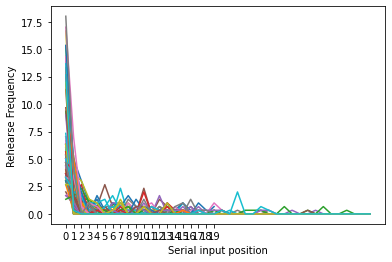

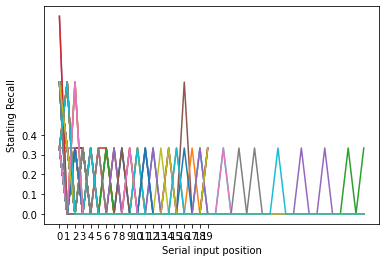

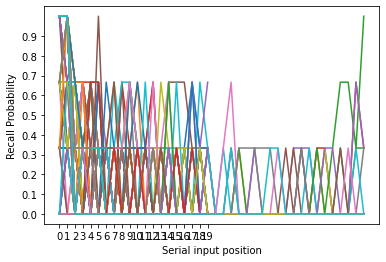

In [5]:
num_agents = 20 #set number of agents per condition
num_lists = 3 #number of lists per agent
distractor_time = 0
#subject = 'controls' # 'controls', 'depressed'

#experimental conditions [rehearsal time, list length] from Murdock 1962 (and van Vugt 2012 [6,20])
experimental_setup = [[2,15],[2,20],[1,20],[1,40],[6,20]] #   

#to save files to different directory for different numbers of agents
output_path = f'./murdock/agents_{num_agents}/'
if not os.path.isdir(output_path):
    os.mkdir(f'murdock/agents_{num_agents}/')
path = output_path


results_dict = {}
for parameter in experimental_setup:
    rh = parameter[0]
    ll = parameter[1]
    
    total_recalled = 0
    total_unique = 0
    
    print("-------------------------------------------------------------------")
    print("Experimental condition:")
    print(f"Number of lists: {num_lists}")
    print(f"Words per list: {ll}")
    print(f"Rehearsal time: {rh} seconds")
    
    for agent in range(num_agents):
        print("-------------------------------------------------------------------")
        print(f"Started for agent_{agent}")
        print(f"Words per list: {ll}, rehearsal time: {rh} sec")
        __init__(agent, rehearsal_time=rh, list_length=ll, list_amount=num_lists, path=path)

        try:
            num_recalled, num_unique, results = do_experiment('depressed',False,list_amount,distractor_time=distractor_time)
            total_recalled += num_recalled
            total_unique += num_unique
        
        except ValueError:
            print("\nAgent recalled 0 items.")

    avg_recall = total_recalled / num_agents
    avg_unique = total_unique / num_agents
    

    results_dict[f'Rate: {rh}, Items: {ll}'] = [avg_recall, avg_unique]
    
    print(f"Experimental Condition\nWords per list: {ll}, rehearsal time: {rh} sec")
    print(f"\nAverage number of recalled words ({num_agents} agents): {avg_recall}")
    print(f"Unique: {avg_unique}")

for key, value in results_dict.items():
    print(f'\n{key}')
    print(f'\nAverage number of recalled words: {value[0]}')
    print(f'\nAverage number of unique words: {value[1]}')
    print('-------------------------------------------------------------\n')
    



Rate: 2, Items: 15

Average number of recalled words: 3.0

Average number of unique words: 2.85
-------------------------------------------------------------


Rate: 2, Items: 20

Average number of recalled words: 3.05

Average number of unique words: 3.05
-------------------------------------------------------------


Rate: 1, Items: 20

Average number of recalled words: 3.7

Average number of unique words: 3.5
-------------------------------------------------------------


Rate: 1, Items: 40

Average number of recalled words: 3.65

Average number of unique words: 3.6
-------------------------------------------------------------


Rate: 6, Items: 20

Average number of recalled words: 2.2

Average number of unique words: 2.1
-------------------------------------------------------------

15-2
P(First_Item): 0.82
P(Final_Item): 0.05
Avg PLI: 0.0
20-2
P(First_Item): 0.72
P(Final_Item): 0.03
Avg PLI: 0.0
20-1
P(First_Item): 0.48
P(Final_Item): 0.18
Avg PLI: 0.0
40-1
P(First_Item): 0.42
P(

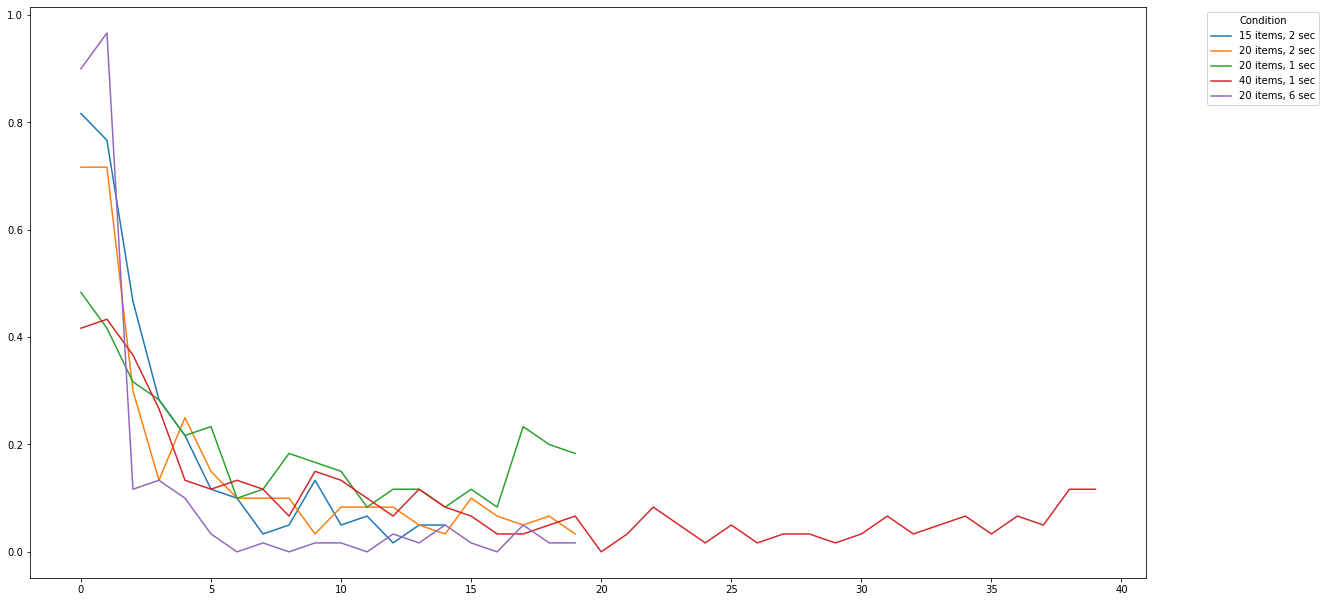

In [6]:
max_list_length = 40
f, ax = plt.subplots(1) #set up plot

f.set_size_inches(20, 10.5)

for key, value in results_dict.items():
    print(f'\n{key}')
    print(f'\nAverage number of recalled words: {value[0]}')
    print(f'\nAverage number of unique words: {value[1]}')
    print('-------------------------------------------------------------\n')

for parameter in experimental_setup:
    rh = parameter[0] #rehearsal time
    ll = parameter[1] #words per list

    files = [] #Storing all the relevant files to work on them later
    pattern = f"words_{ll}_lists_{num_lists}_rh_time_{rh}*.txt" # Pattern for matching the filename for data retrieval
    for file in os.listdir(path): #Lists all the files and directories within the folder
        if fnmatch.fnmatch(file, pattern): #matches the above declared patter with the filenames from listdir()
            files.append(file) #Appends the file to make it available for later use.
    
    # Initializing all the parameters needed for the plots
    idx = [0,1,2]
    xlabel = 'Serial Input Position'
    ylabel = ['Rehearse Frequency','Starting Probability','Recall Probability']
    xticks_len = max_list_length+10
    rehearse_frequency = []
    recall_probability = []
    first_recall = []
    pli_list = []
    
    for file in files: #load the result files
        with open(f"{path}/{file}") as f:
            results = json.load(f)
            if results['recall_probability']['data']:
                recall_probability.append(results['recall_probability']['data'])
            else: #if an agent failed to recall anything...
                recall_probability.append([0]*ll)
            if results['pli']['data']:
                pli_list.append(results['pli']['data'])
            else:
                pli_list.append([0]*ll)
                
                
    #calculating avg recall probability per input position across agents            
    avg_recall_probs = [sum(x)/num_agents for x in zip(*recall_probability)]
    
    #print(pli_list)
    
    avg_pli = [sum(x)/num_agents for x in zip(*pli_list)]
    
    print(f'{ll}-{rh}\nP(First_Item): {round(avg_recall_probs[0],2)}\nP(Final_Item): {round(avg_recall_probs[-1],2)}\nAvg PLI: {sum(avg_pli)/(num_lists-1)}')
    
    #plot results
    x = range(ll)
    ax.plot(x, avg_recall_probs, label = f"{ll} items, {rh} sec")
    #ax.set_xlim([0,ll])
    #ax.set_ylim([-.1,1])
    
ax.legend()
ax.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left') #fontsize='xx-small')

#("murdock/images/"+subject+"_"+filename, bbox_inches='tight')

##### do_experiment flow:

1. check_and_create_lists
	a. create_lists
	   return word_lists_dict
		i. add_words
            adds to word_lists_dict

2. setup_experiment
    returns window
      model is loaded


3. setup_dm


4. prepare_for_recall


5. close_exp_window


6. analysis
    return result_dict
        contains pstart, pstay, pstop
    prints Avg recall transitions
    
    prints Avg negative thought train length
   

In [7]:
objects = []
with (open(r"word_lists\word_lists_dict_20_3.pickle", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [8]:
results_dict

{'Rate: 2, Items: 15': [3.0, 2.85],
 'Rate: 2, Items: 20': [3.05, 3.05],
 'Rate: 1, Items: 20': [3.7, 3.5],
 'Rate: 1, Items: 40': [3.65, 3.6],
 'Rate: 6, Items: 20': [2.2, 2.1]}

In [9]:
#for idx, (key, val) in enumerate(word_lists_dict.items()):
#    print(idx, (key, val))

In [10]:
file = open(f"word_lists/word_lists_dict_20_3.pickle","rb")
#file = open(f"word_lists_dict_100_items_only.pickle","rb")
word_lists_dict = pickle.load(file)  
file.close()

#word_lists_dict

In [11]:
actr.reset()
setup_dm(word_lists_dict)
actr.sdp(':creation-time', -1000, ':reference-list', list(np.linspace(0, -1000, 50)))


[[-1000,
  [0.0,
   -20.408,
   -40.816,
   -61.224,
   -81.633,
   -102.041,
   -122.449,
   -142.857,
   -163.265,
   -183.673,
   -204.082,
   -224.49,
   -244.898,
   -265.306,
   -285.714,
   -306.122,
   -326.531,
   -346.939,
   -367.347,
   -387.755,
   -408.163,
   -428.571,
   -448.98,
   -469.388,
   -489.796,
   -510.204,
   -530.612,
   -551.02,
   -571.429,
   -591.837,
   -612.245,
   -632.653,
   -653.061,
   -673.469,
   -693.878,
   -714.286,
   -734.694,
   -755.102,
   -775.51,
   -795.918,
   -816.327,
   -836.735,
   -857.143,
   -877.551,
   -897.959,
   -918.367,
   -938.776,
   -959.184,
   -979.592,
   -1000.0]],
 [-1000,
  [0.0,
   -20.408,
   -40.816,
   -61.224,
   -81.633,
   -102.041,
   -122.449,
   -142.857,
   -163.265,
   -183.673,
   -204.082,
   -224.49,
   -244.898,
   -265.306,
   -285.714,
   -306.122,
   -326.531,
   -346.939,
   -367.347,
   -387.755,
   -408.163,
   -428.571,
   -448.98,
   -469.388,
   -489.796,
   -510.204,
   -530.612,
   -

In [12]:
#word_lists_dict

In [13]:
recalled_words.items()

dict_items([(0, [('neutral', '990', 'LIST0'), ('neutral', '748', 'LIST0')]), (1, [('neutral', '164', 'LIST1'), ('neutral', '195', 'LIST1')]), (2, [('neutral', '611', 'LIST2'), ('neutral', '552', 'LIST2')])])

In [14]:
    for key, val in recalled_words.items():
        print(key, current_list)
        print(val)
        for word in val:
            print(word[0:2])

0 2
[('neutral', '990', 'LIST0'), ('neutral', '748', 'LIST0')]
('neutral', '990')
('neutral', '748')
1 2
[('neutral', '164', 'LIST1'), ('neutral', '195', 'LIST1')]
('neutral', '164')
('neutral', '195')
2 2
[('neutral', '611', 'LIST2'), ('neutral', '552', 'LIST2')]
('neutral', '611')
('neutral', '552')


In [15]:
actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\rumination_free_recall_model_v1.lisp")

True

In [16]:
setup_dm(word_lists_dict)